In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os

sys.path.append("..")
from src.datasets.read_dataset import RealDataSet
from src.models.diverse_ensemble import DiverseEnsembleMLP

custom_params = {"axes.grid": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context("talk")
pl.rcParams.update({"figure.autolayout": True})

/home/awx1303337/miniforge3/envs/stenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_statistics(dataset: RealDataSet, y_l, y_u, y_val, num_classes):
    n_lab = len(y_l)
    n_unlab = len(y_u) if y_u is not None else 0
    n_train = n_lab + n_unlab
    n_val = len(y_val)
    n_all = n_train + n_val

    # Print statistics
    print(f"Total number of data:           {len(dataset.y)}")
    print(f"Split is valid:                 {n_all == len(dataset.y)}")
    print(f"Feature dimension:              {dataset.X.shape[1:]}")
    print(f"Total number of training data:  {n_train}")
    print(f"Number of classes:              {num_classes}")
    print(f"Number of labeled samples:      {n_lab} ({n_lab / n_train * 100:.2f}%)")
    print(f"Number of unlabeled samples:    {n_unlab} ({n_unlab / n_train * 100:.2f}%)")
    print(f"Number of validation samples:   {n_val} ({n_val / n_train * 100:.2f}%)")


def get_base_classier(
    dataset_name,
    seed,
    nb_lab_samples_per_class,
    selection_bias,
    num_epochs,
    gamma,
):
    # Fixed params
    test_size = 0.25
    n_iters = 100
    n_classifiers = 5

    # Data split
    dataset = RealDataSet(dataset_name=dataset_name, seed=seed)

    # Percentage of labeled data
    num_classes = len(list(set(dataset.y)))
    ratio = num_classes / ((1 - test_size) * len(dataset.y))
    lab_size = nb_lab_samples_per_class * ratio

    # Split
    x_l, x_u, y_l, y_u, x_test, y_test, n_classes = dataset.get_split(
        test_size=test_size, lab_size=lab_size, selection_bias=selection_bias
    )

    # Define base classifier
    base_classifier = DiverseEnsembleMLP(
        num_epochs=num_epochs,
        gamma=gamma,
        n_iters=n_iters,
        n_classifiers=n_classifiers,
        device="cpu",
        verbose=False,
        random_state=seed,
    )

    # Train
    base_classifier.fit(x_l, y_l, x_u)

    return base_classifier, x_u, y_u


def get_barplots(
    dataset_name,
    seed,
    nb_lab_samples_per_class,
    selection_bias,
    num_epochs,
    gamma_u,
    figsize=None,
    save=False,
    path="figures",
    filename=None,
    format="svg",
    dpi=300,
    side_caption=None,
):
    base_classifier, x_u, y_u = get_base_classier(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
    )
    conf_types = ["proj_head", "similarity"]
    real_names_conf_types = {
        "proj_head": "Softmax Prediction Probability",
        "similarity": "$\mathcal{T}$-similarity",
    }
    # plot confidence
    fig, axes = pl.subplots(nrows=1, ncols=len(conf_types), figsize=figsize)
    ymax = 0
    for i, conf_type in enumerate(conf_types):
        if conf_type == "proj_head":
            pred_conf = base_classifier.predict_proba(x_u).max(axis=-1)
        else:
            pred_conf = base_classifier.predict_t_similarity(x_u)
        y_pred = base_classifier.predict(x_u)

        pred_conf_cor = pred_conf[y_u == y_pred]
        pred_conf_err = pred_conf[y_u != y_pred]

        values_cor, bins = np.histogram(pred_conf_cor, np.arange(11) / 10)
        values_err, bins = np.histogram(pred_conf_err, np.arange(11) / 10)

        # if ymax is not None:
        # ymax = max(ymax, np.max(values_cor + values_err))
        # else:
        # ymax = np.max(values_cor + values_err)

        bins_ = (bins - 0.05)[1:]
        axes[i].grid(alpha=0.2, axis="x")
        axes[i].bar(
            bins_,
            values_err + values_cor,
            color="#d8d5f2",  # "#E4EFFF",
            edgecolor="black",
            width=0.1,
            linewidth=1.25,
            alpha=0.4,
            label="Correct Prediction",
        )
        axes[i].bar(
            bins_,
            values_err,
            fill=False,
            # color="#84a2c6",
            edgecolor="tab:blue",
            hatch="///",
            width=0.1,
            linewidth=0.5,
            label="Wrong Prediction",
        )
        axes[i].set_xlabel("Confidence Value")
        if i == 0 and side_caption is not None:
            axes[i].set_ylabel(f"{side_caption} \n Count")
        else:
            axes[i].set_ylabel("Count")
        axes[i].set_title(real_names_conf_types[conf_type])
        ax = axes[i]
        ax.grid(False)
        ax.spines["left"].set_linewidth(1)
        ax.spines["right"].set_linewidth(1)
        ax.spines["top"].set_linewidth(1)
        ax.spines["bottom"].set_linewidth(1)
        ax.tick_params(direction="out", length=6)
        _, ymax_temp = ax.get_ylim()
        ymax = max(ymax, ymax_temp)

    for ax in axes:
        ymin = 0
        tol = 1e-1 * ymax
        ax.set_ylim(0, ymax + tol)
        low = (ymax - ymin) * 0.1
        N = 3
        yticks = np.linspace(ymin + low, ymax - low, N)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks.astype(int))
        ax.locator_params(axis="x", nbins=5)

    lines_labels = [fig.axes[1].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(
        lines,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
        fancybox=True,
        borderaxespad=0,
        shadow=True,
        ncol=2,
    )

    pl.tight_layout()
    if save:
        if filename is None:
            filename = f"missing_title.{format}"
        pl.savefig(
            os.path.join(path, filename), format=format, bbox_inches="tight", dpi=dpi
        )
    pl.show()

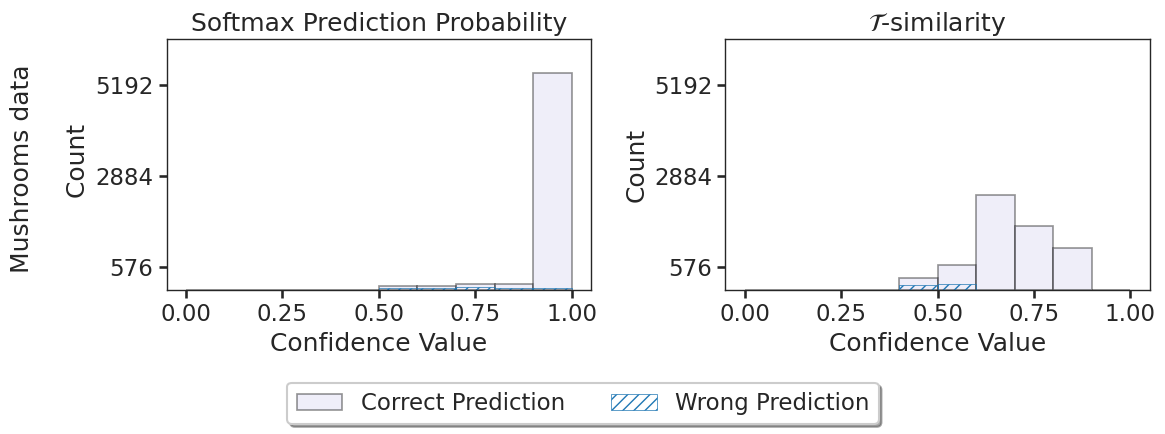

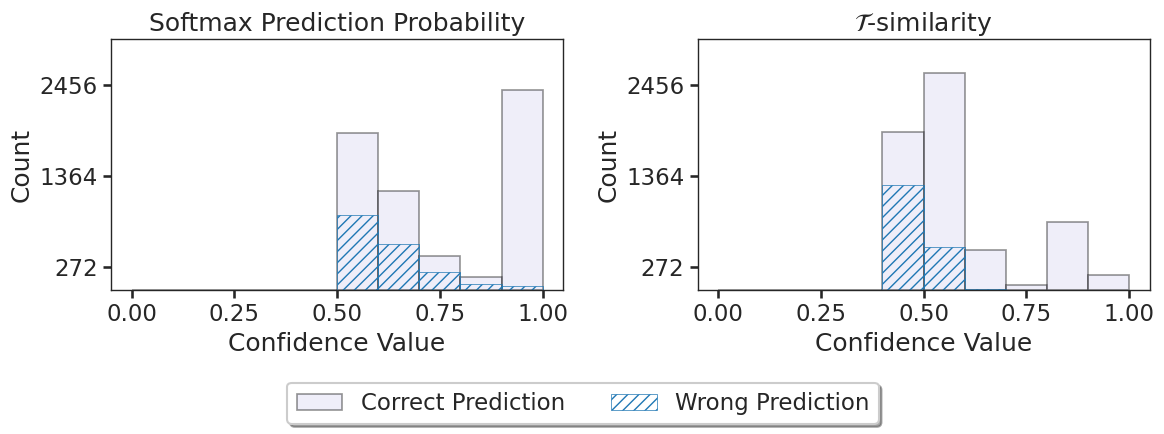

In [4]:
## Less size
dataset_name = "mushrooms"
seed = 42
nb_lab_samples_per_class = 40
num_epochs = 5
gamma = 1
figsize = (12, 4)
save = False
format = "pdf"
dpi = 100
for selection_bias in [False, True]:
    if selection_bias == False:
        side_caption = "Mushrooms data \n"
    else:
        side_caption = None
    filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
    get_barplots(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma,
        figsize=figsize,
        save=save,
        format=format,
        filename=filename,
        dpi=dpi,
        side_caption=side_caption,
    )

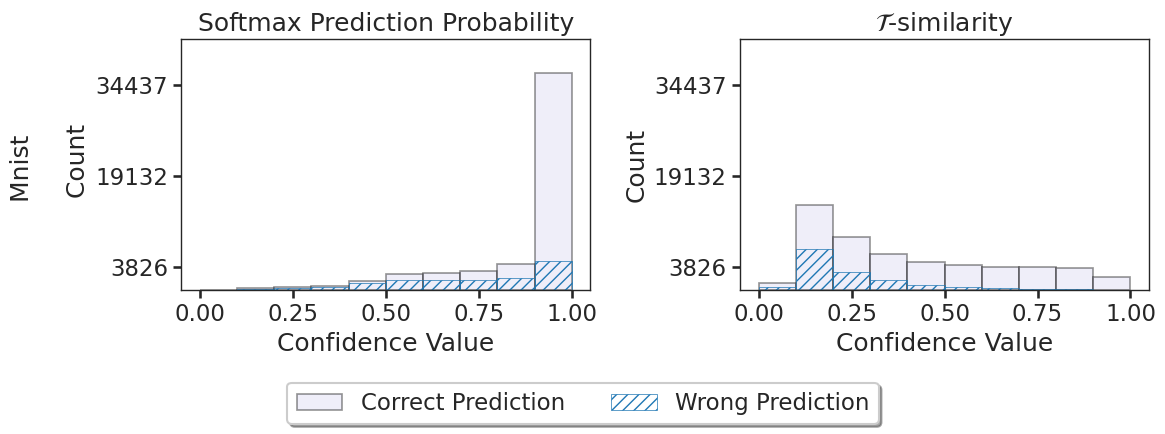

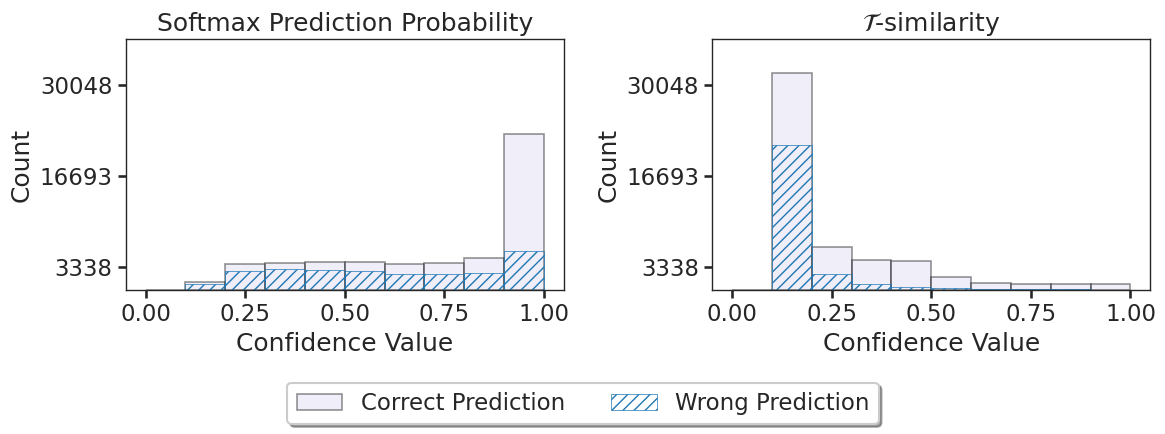

In [94]:
## Less size
dataset_name = "mnist"
seed = 0
nb_lab_samples_per_class = 10
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
format = "pdf"
dpi = 100
for selection_bias in ["balanced", "pca"]:
    if selection_bias == "balanced":
        side_caption = "Mnist \n"
    else:
        side_caption = None
    filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
    get_barplots(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
        figsize=figsize,
        save=save,
        format=format,
        filename=filename,
        dpi=dpi,
        side_caption=side_caption,
    )

/home/vfeofanov/low-density-separation/data/MNIST/raw/


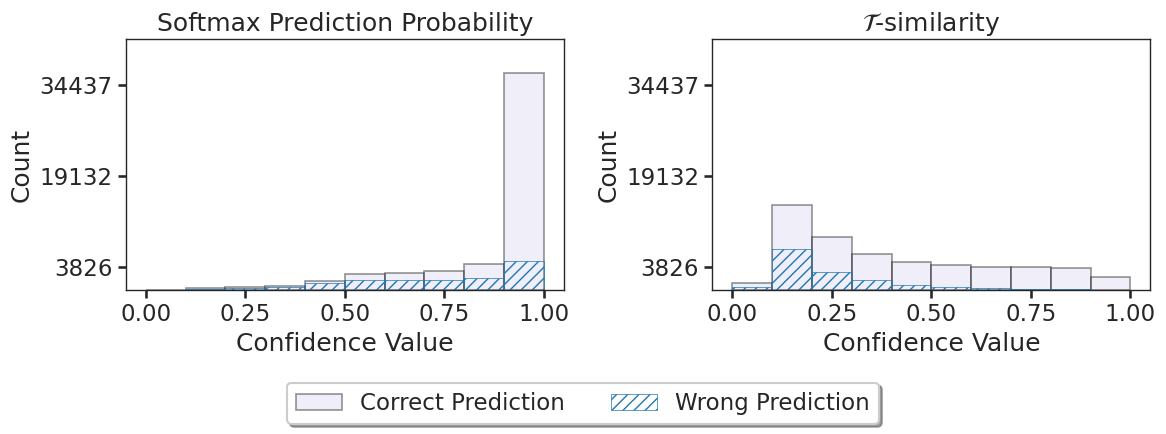

/home/vfeofanov/low-density-separation/data/MNIST/raw/


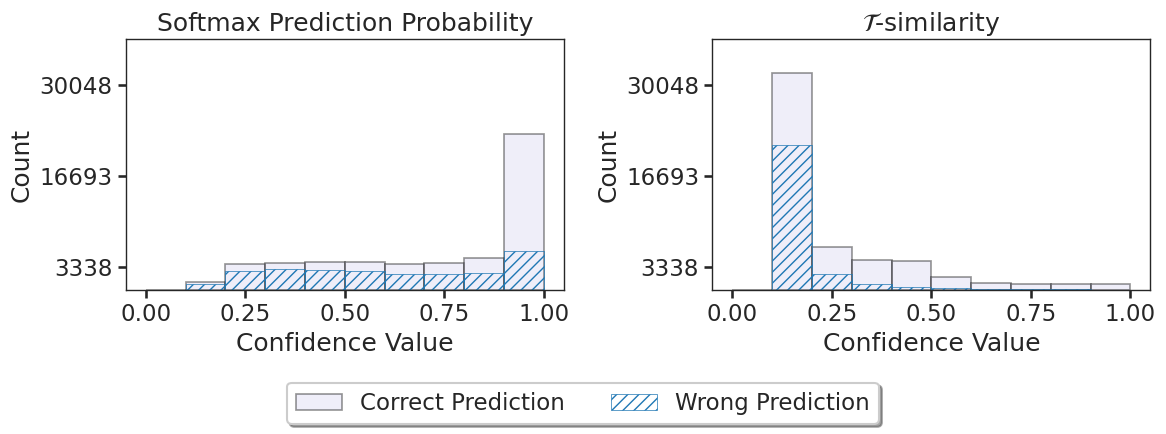

In [13]:
## Less size
dataset_name = "mnist"
seed = 0
nb_lab_samples_per_class = 10
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
format = "pdf"
dpi = 100
for selection_bias in ["balanced", "pca"]:
    if selection_bias == "balanced":
        side_caption = None
    else:
        side_caption = None
    filename = f"calibrated_similarity_crop_{dataset_name}_{selection_bias}.{format}"
    get_barplots(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
        figsize=figsize,
        save=save,
        format=format,
        filename=filename,
        dpi=dpi,
        side_caption=side_caption,
    )

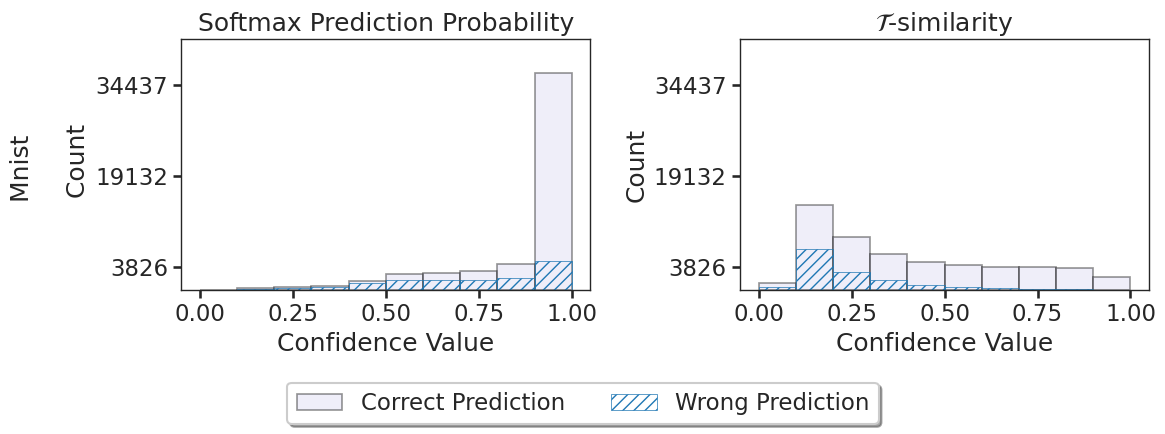

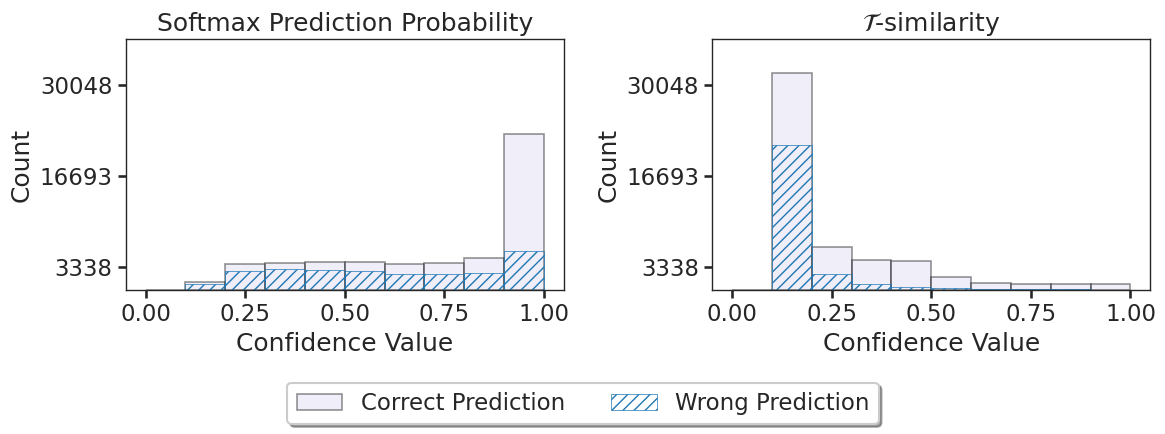

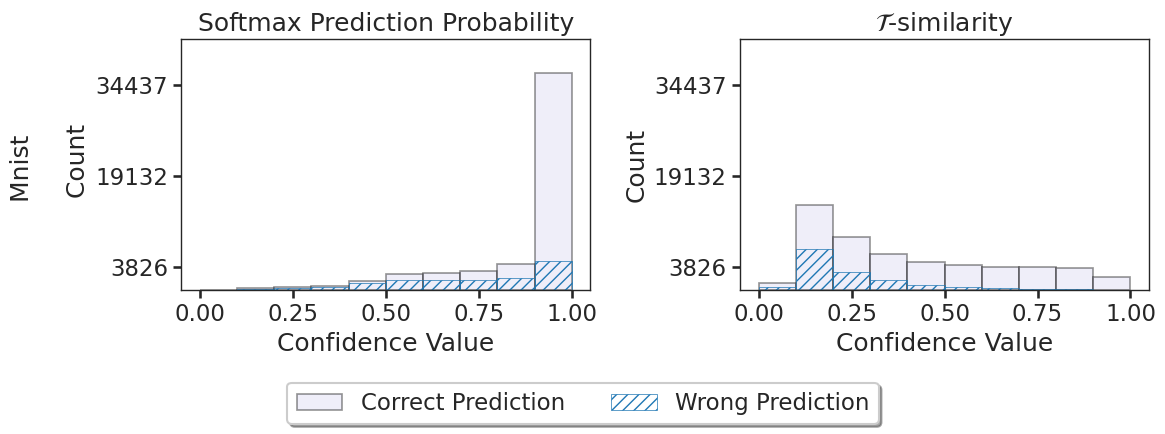

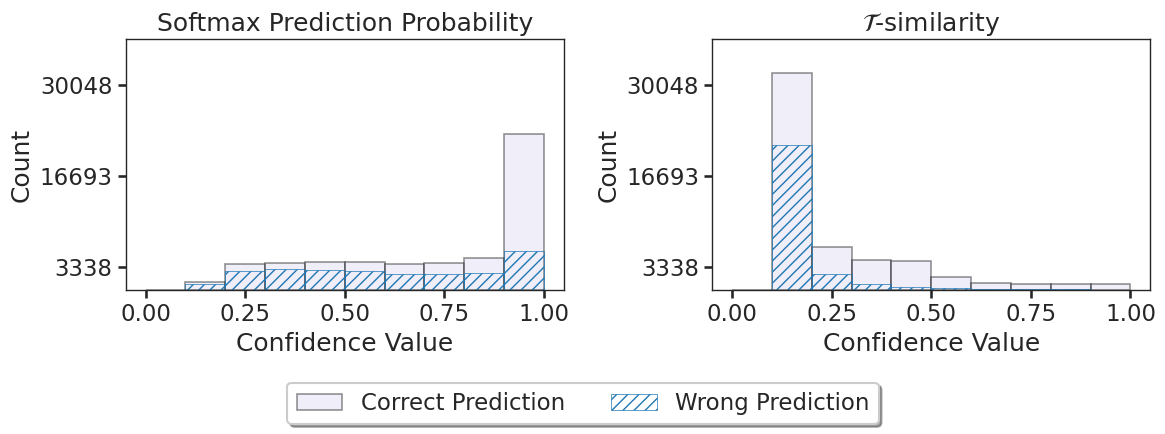

In [95]:
dataset_name = "mnist"
seed = 0
nb_lab_samples_per_class = 10
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
for format in ["svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Mnist \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            side_caption=side_caption,
        )

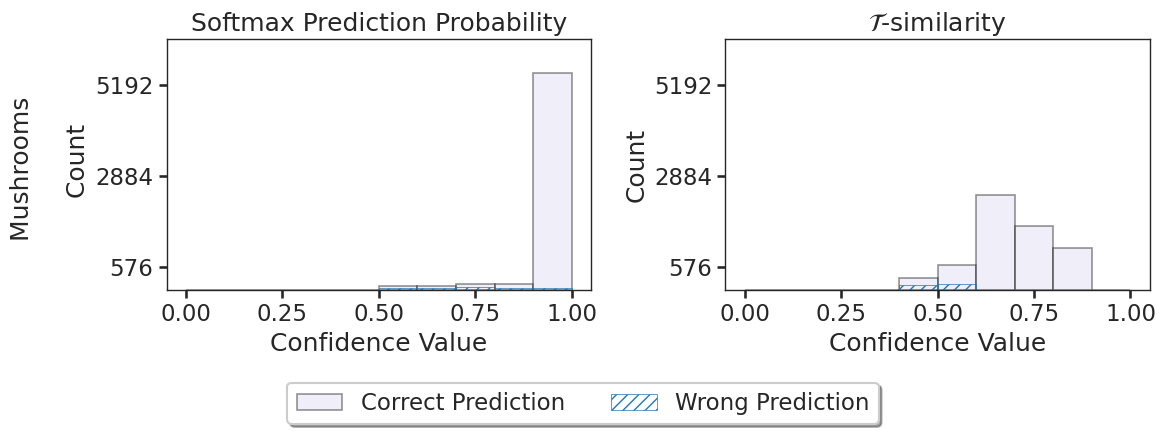

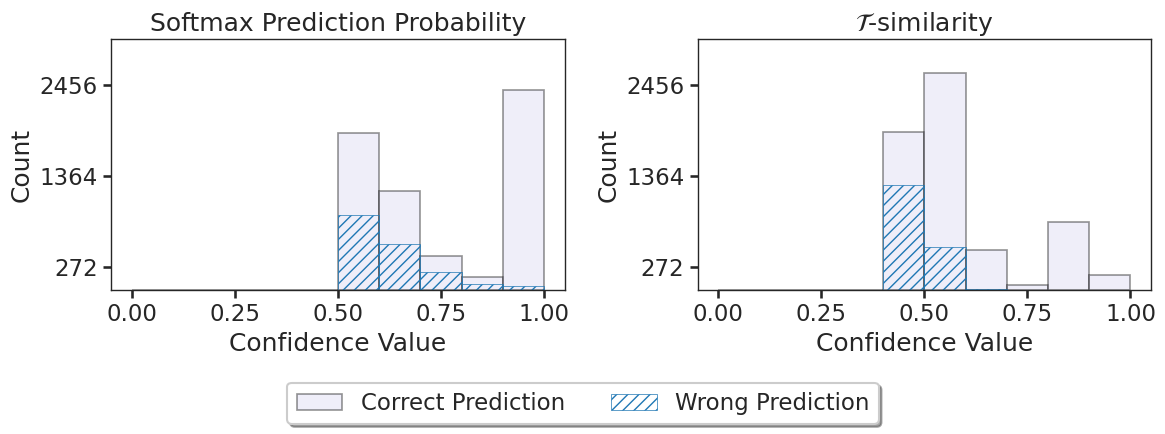

In [96]:
## Less size
dataset_name = "mushrooms"
seed = 42
nb_lab_samples_per_class = 40
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
format = "pdf"
dpi = 100
for selection_bias in ["balanced", "pca"]:
    if selection_bias == "balanced":
        side_caption = "Mushrooms \n"
    else:
        side_caption = None
    filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
    get_barplots(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
        figsize=figsize,
        save=save,
        format=format,
        filename=filename,
        dpi=dpi,
        side_caption=side_caption,
    )

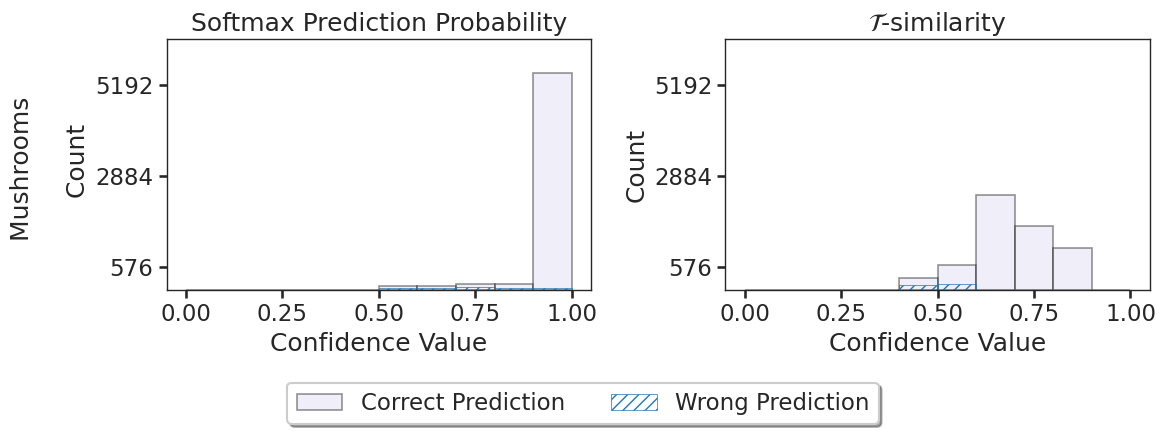

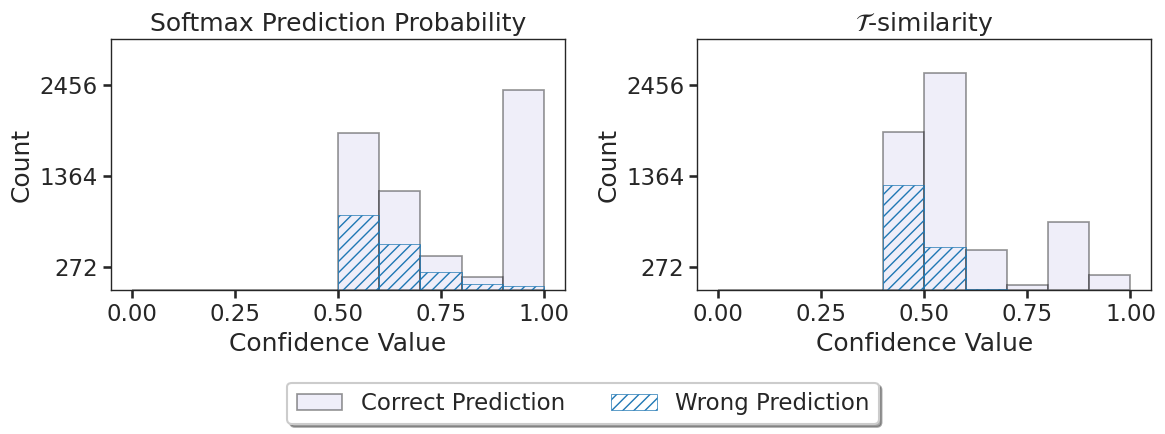

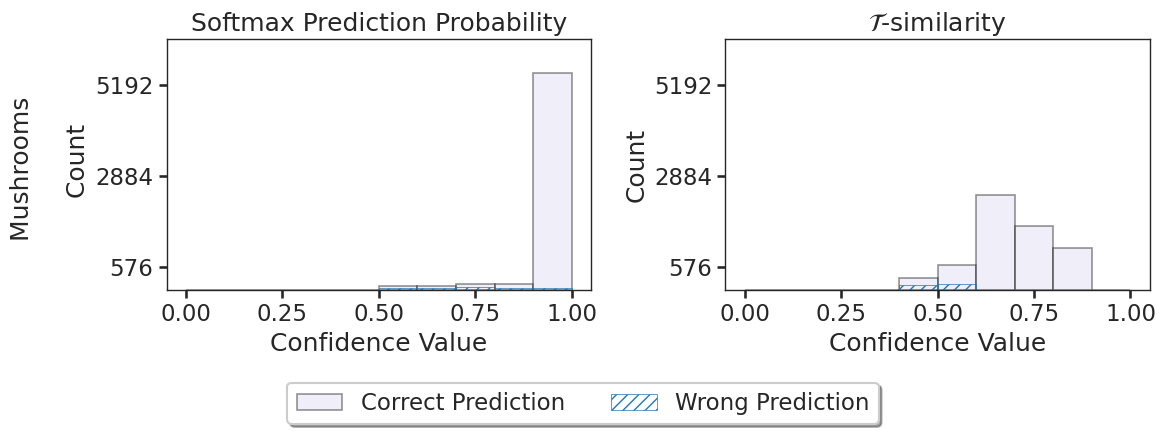

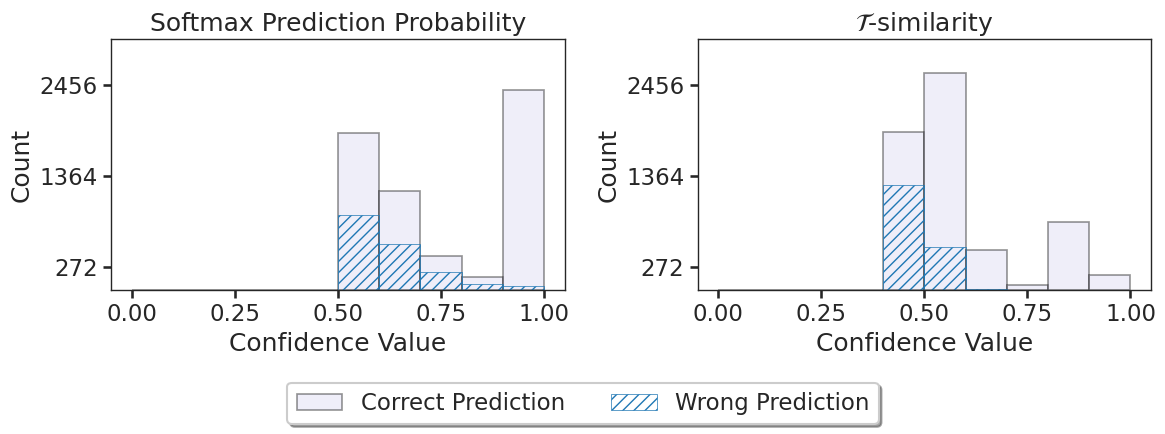

In [97]:
dataset_name = "mushrooms"
seed = 42
nb_lab_samples_per_class = 40
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
for format in ["svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Mushrooms \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            side_caption=side_caption,
        )

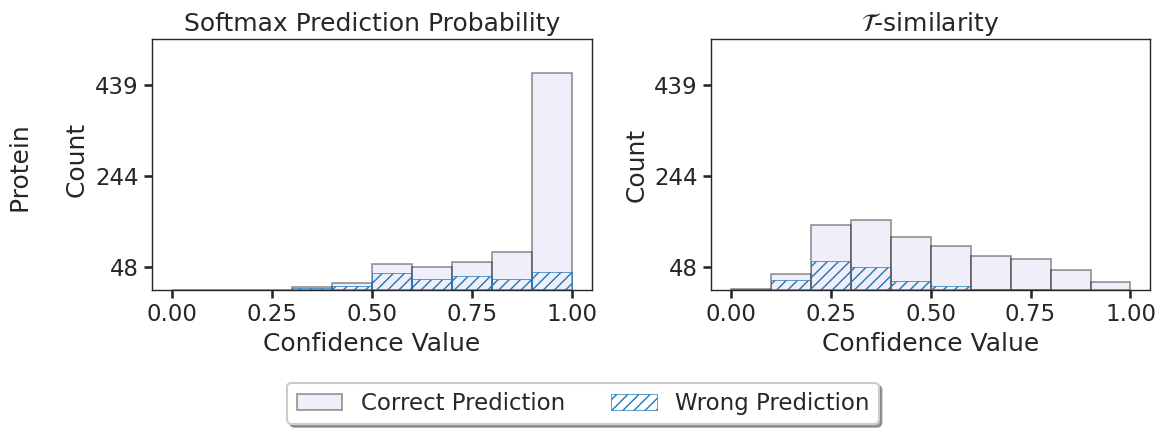

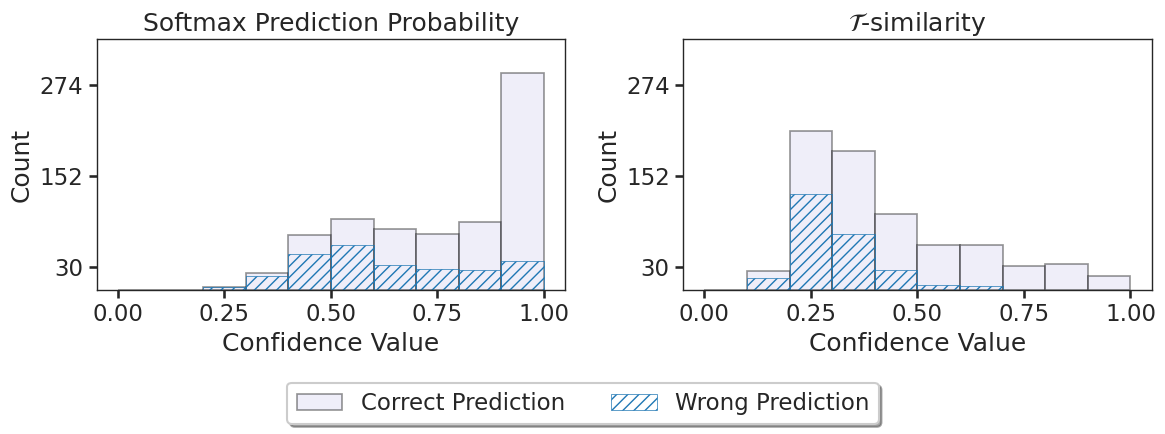

In [98]:
dataset_name = "protein"
seed = 0
nb_lab_samples_per_class = 10
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
format = "pdf"
dpi = 100
for selection_bias in ["balanced", "pca"]:
    if selection_bias == "balanced":
        side_caption = "Protein \n"
    else:
        side_caption = None
    filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
    get_barplots(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
        figsize=figsize,
        save=save,
        format=format,
        filename=filename,
        dpi=dpi,
        side_caption=side_caption,
    )

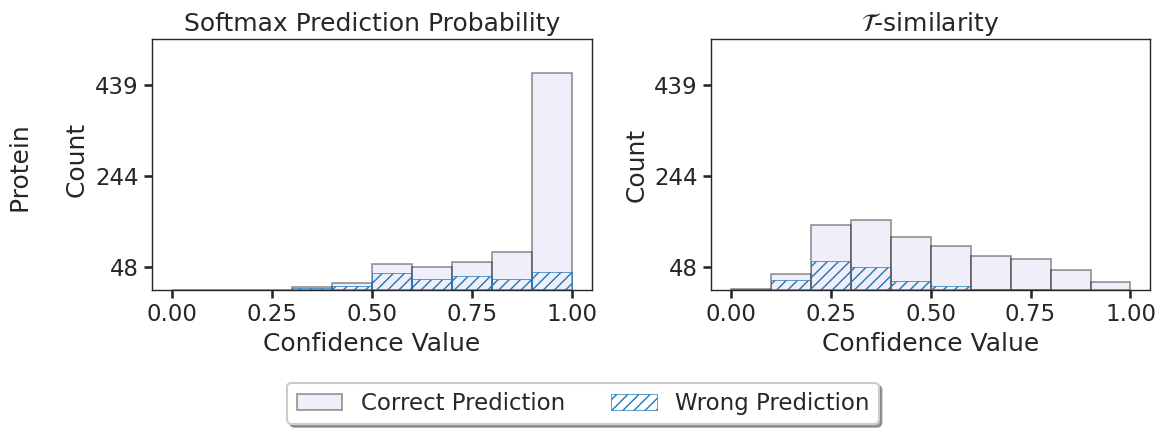

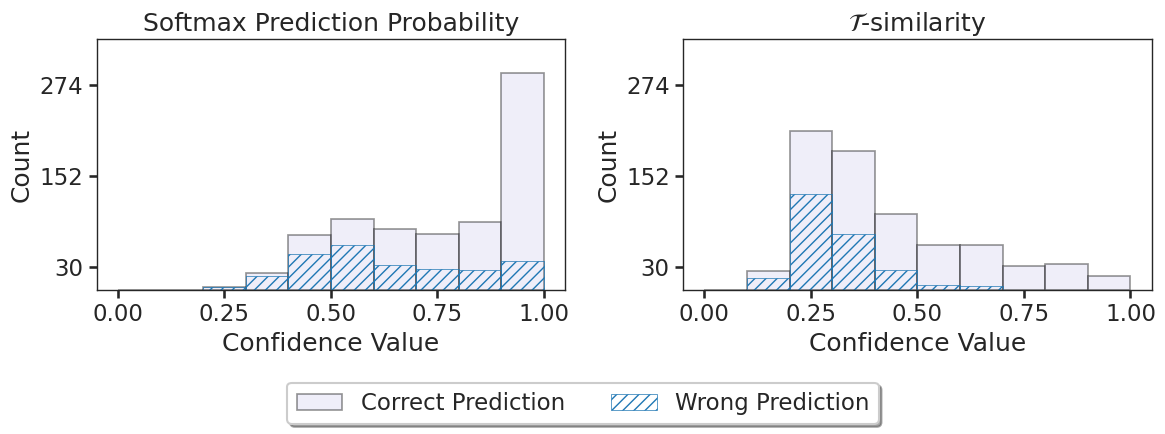

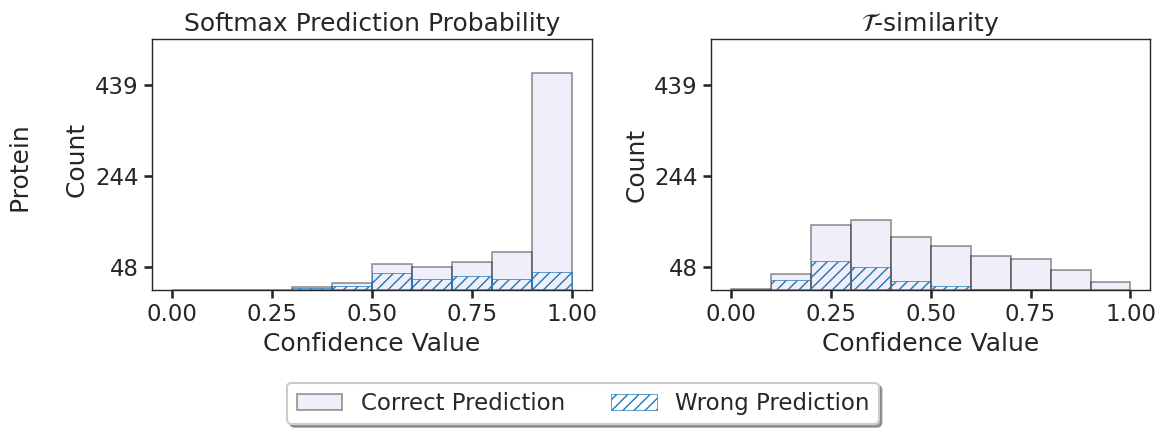

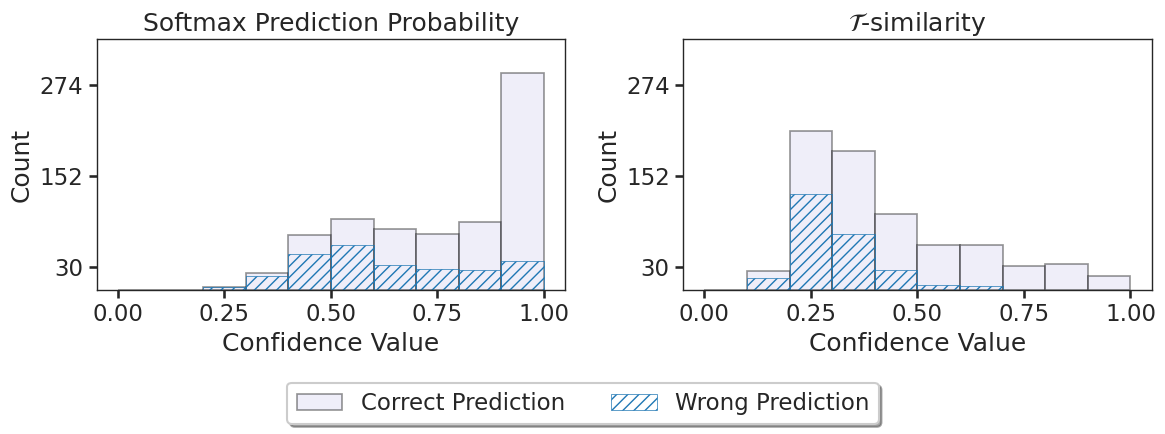

In [99]:
dataset_name = "protein"
seed = 0
nb_lab_samples_per_class = 10
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
for format in ["svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Protein \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            side_caption=side_caption,
        )

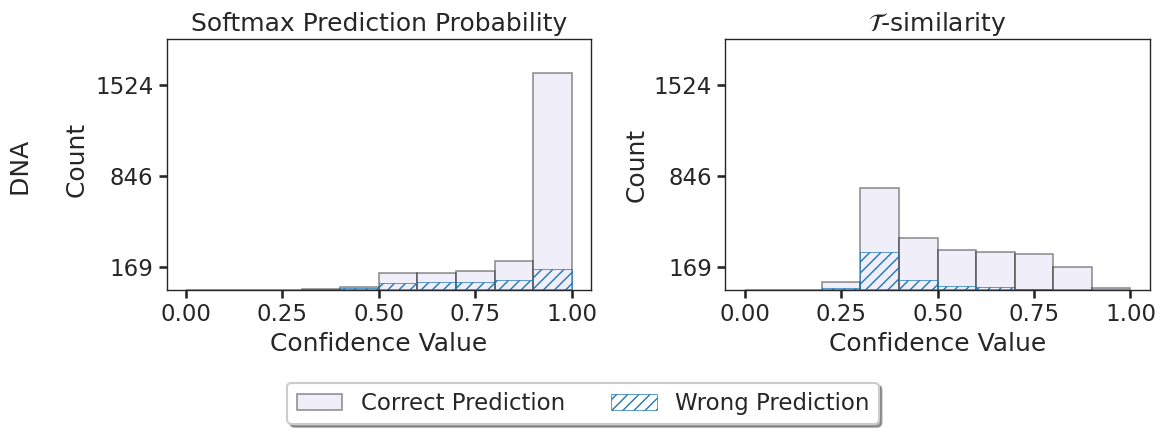

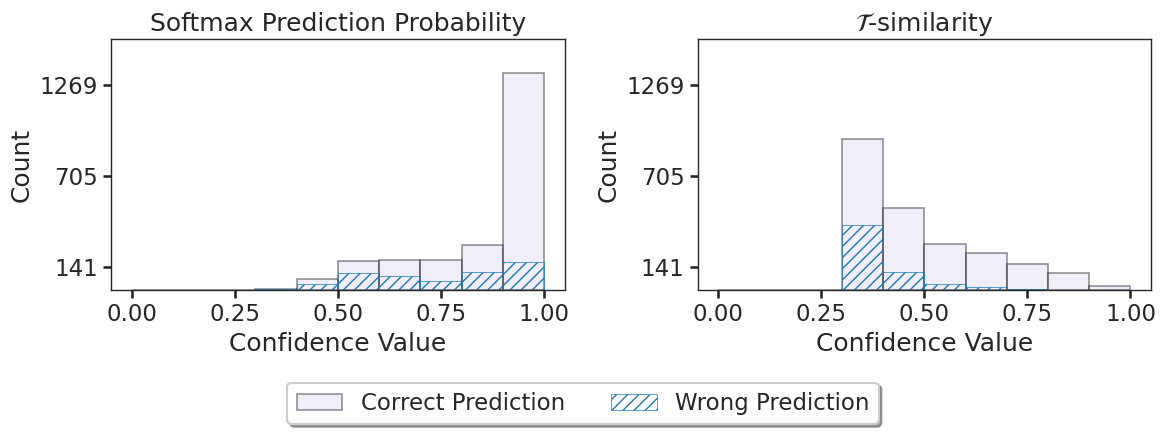

In [100]:
dataset_name = "dna"
seed = 0
nb_lab_samples_per_class = 50
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
format = "pdf"
dpi = 100
for selection_bias in ["balanced", "pca"]:
    if selection_bias == "balanced":
        side_caption = "DNA \n"
    else:
        side_caption = None
    filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
    get_barplots(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
        figsize=figsize,
        save=save,
        format=format,
        filename=filename,
        dpi=dpi,
        side_caption=side_caption,
    )

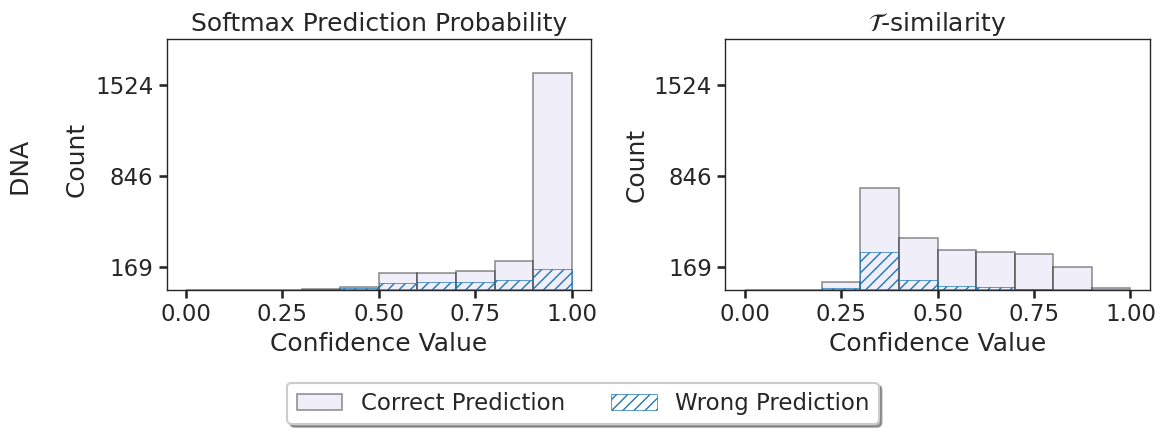

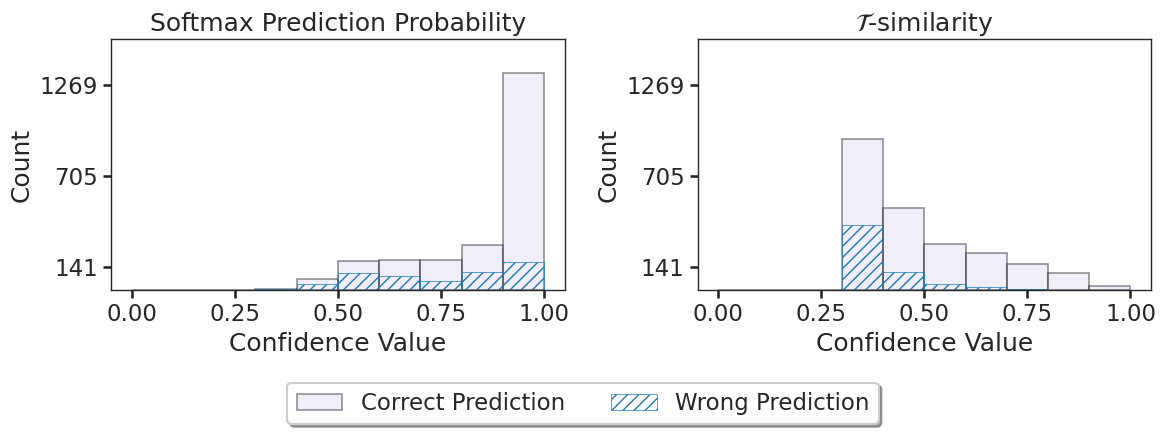

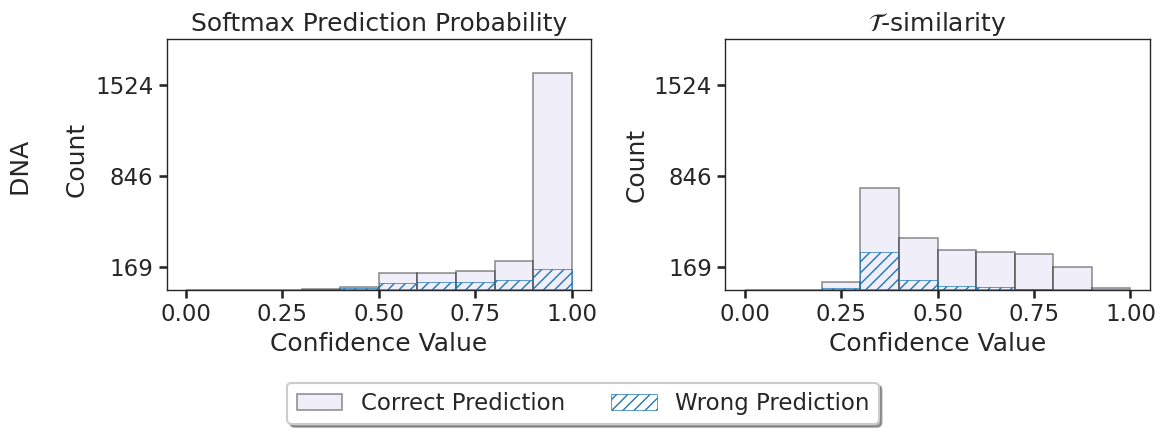

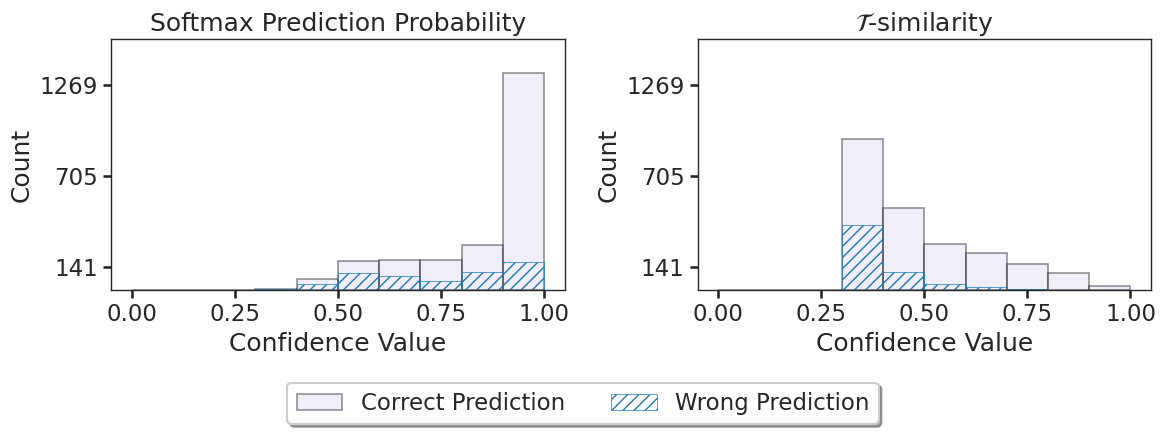

In [101]:
dataset_name = "dna"
seed = 0
nb_lab_samples_per_class = 50
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
for format in ["svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "DNA \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            side_caption=side_caption,
        )

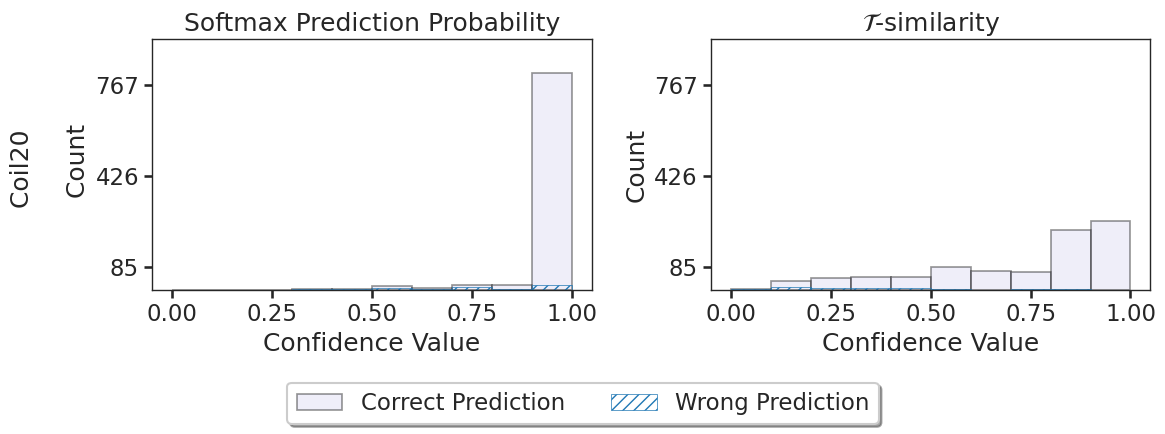

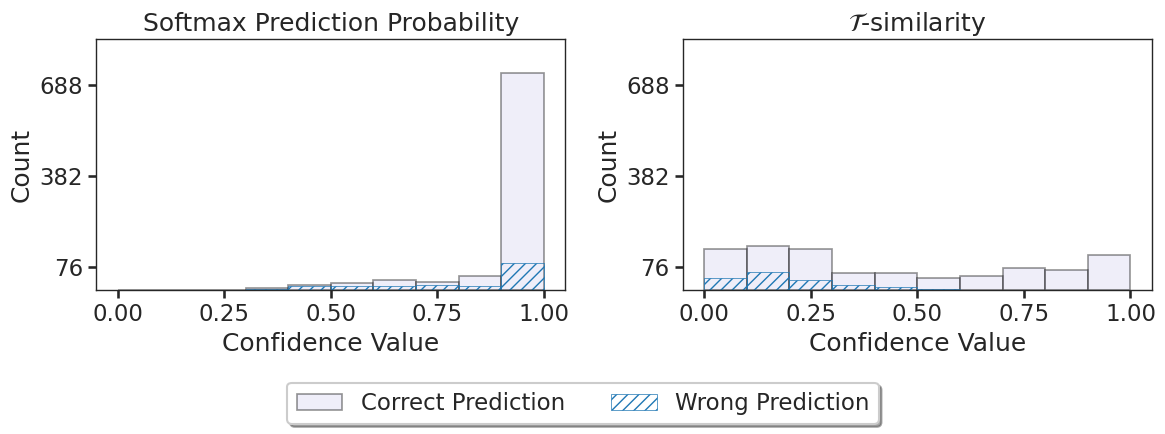

In [102]:
dataset_name = "coil20"
seed = 0
nb_lab_samples_per_class = 10
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
format = "pdf"
dpi = 100
for selection_bias in ["balanced", "pca"]:
    if selection_bias == "balanced":
        side_caption = "Coil20 \n"
    else:
        side_caption = None
    filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
    get_barplots(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
        figsize=figsize,
        save=save,
        format=format,
        filename=filename,
        dpi=dpi,
        side_caption=side_caption,
    )

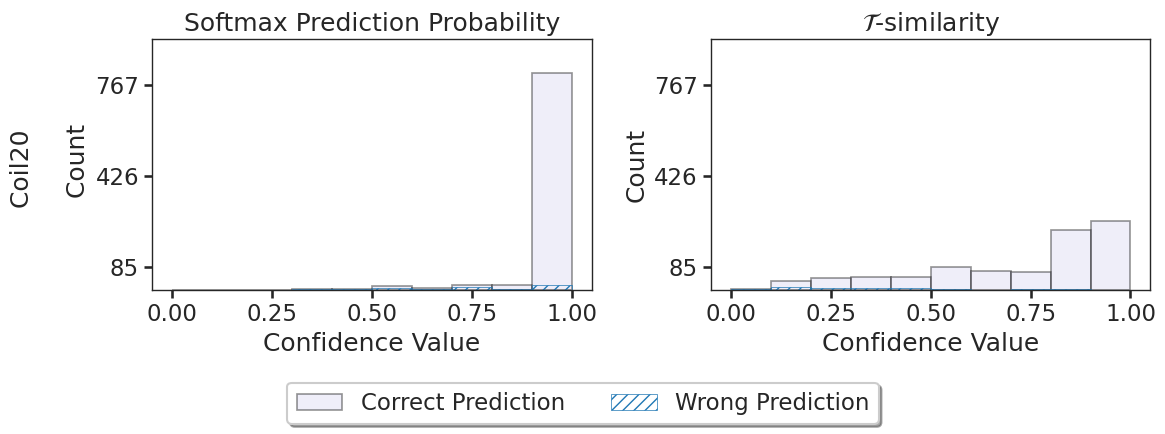

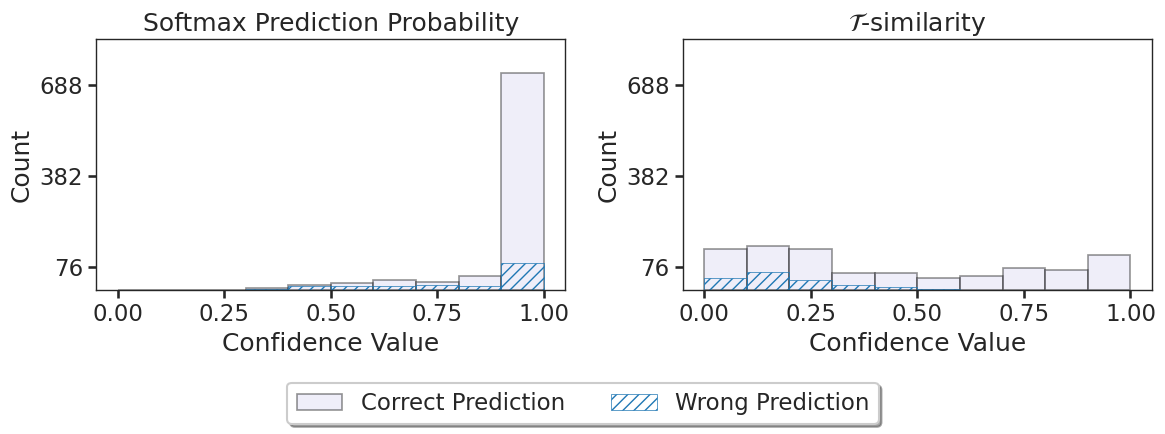

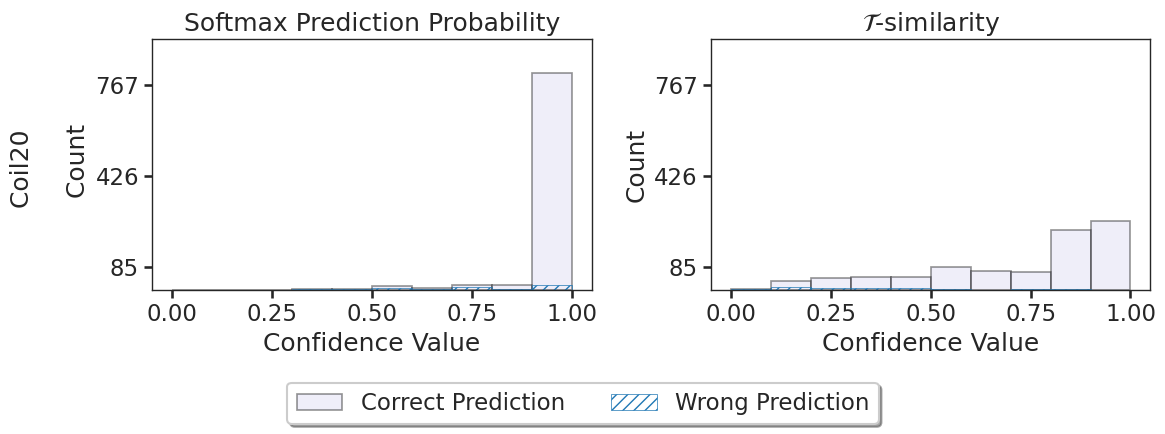

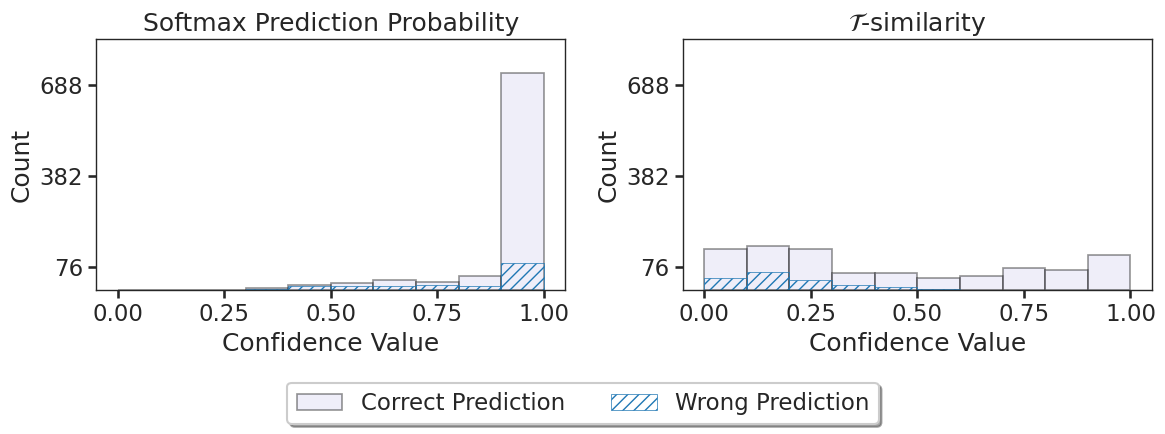

In [103]:
dataset_name = "coil20"
seed = 0
nb_lab_samples_per_class = 10
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
for format in ["svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Coil20 \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            side_caption=side_caption,
        )

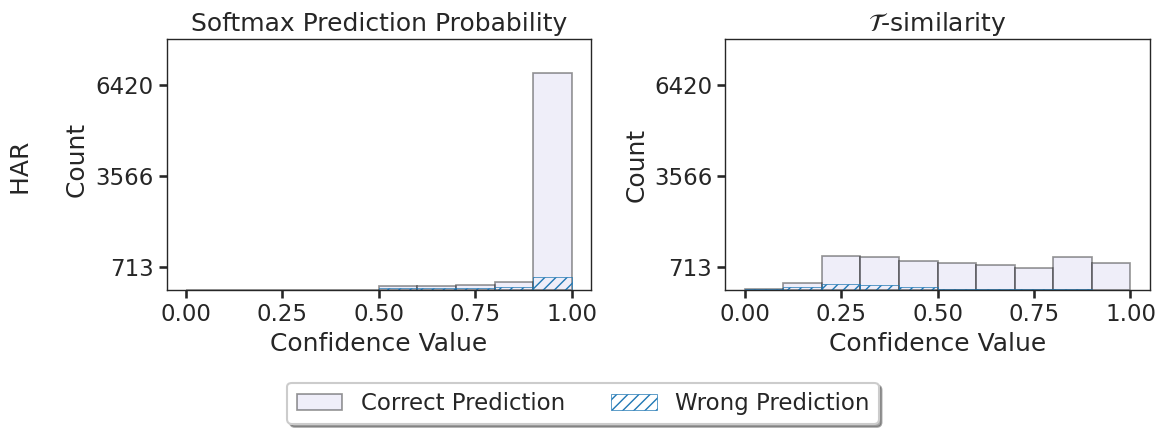

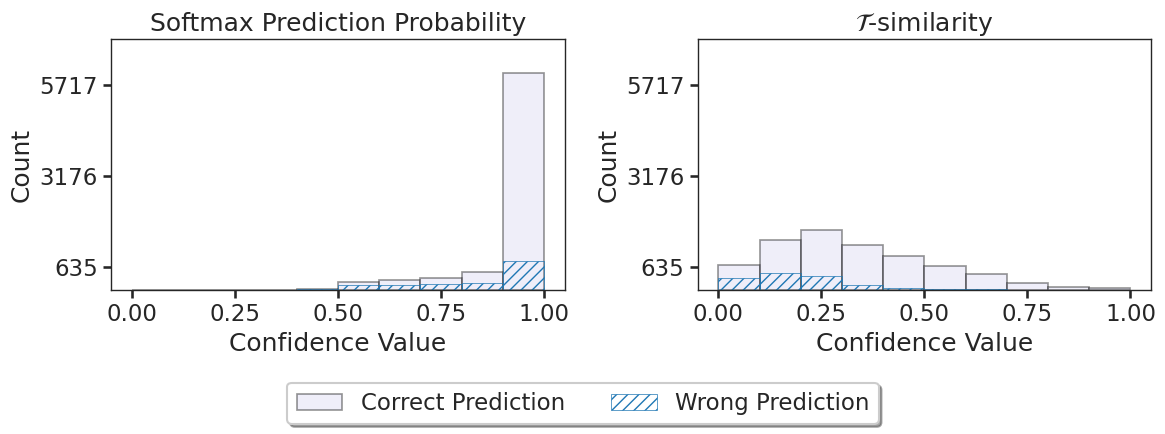

In [104]:
dataset_name = "har"
seed = 0
nb_lab_samples_per_class = 50
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
format = "pdf"
dpi = 100
for selection_bias in ["balanced", "pca"]:
    if selection_bias == "balanced":
        side_caption = "HAR \n"
    else:
        side_caption = None
    filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
    get_barplots(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
        figsize=figsize,
        save=save,
        format=format,
        filename=filename,
        dpi=dpi,
        side_caption=side_caption,
    )

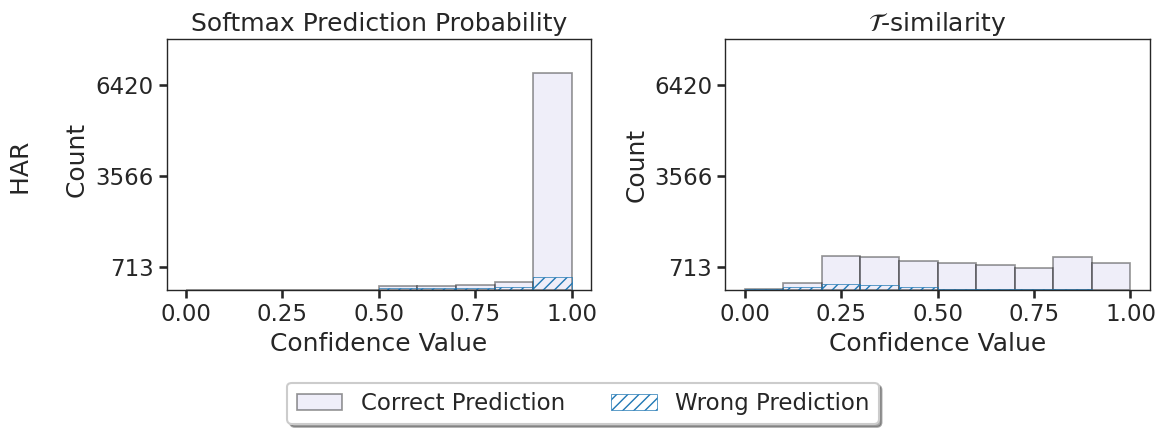

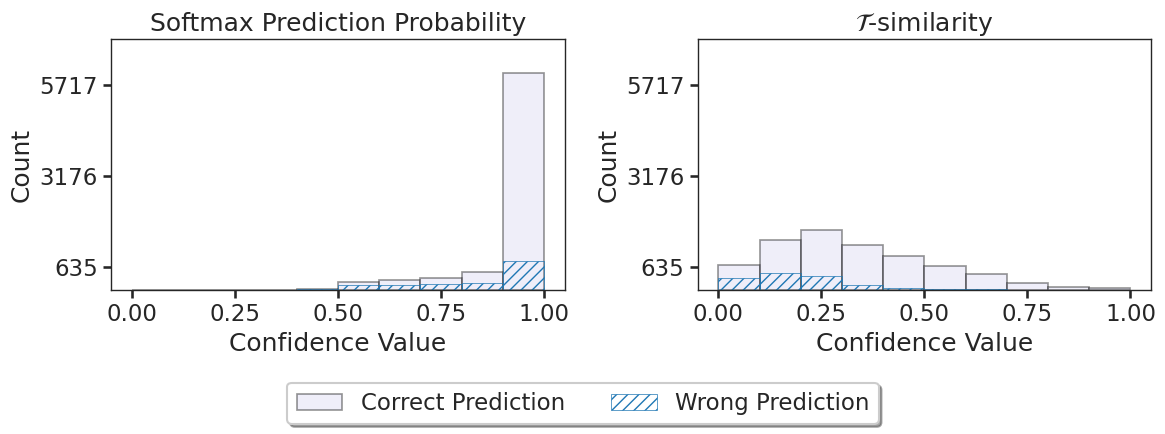

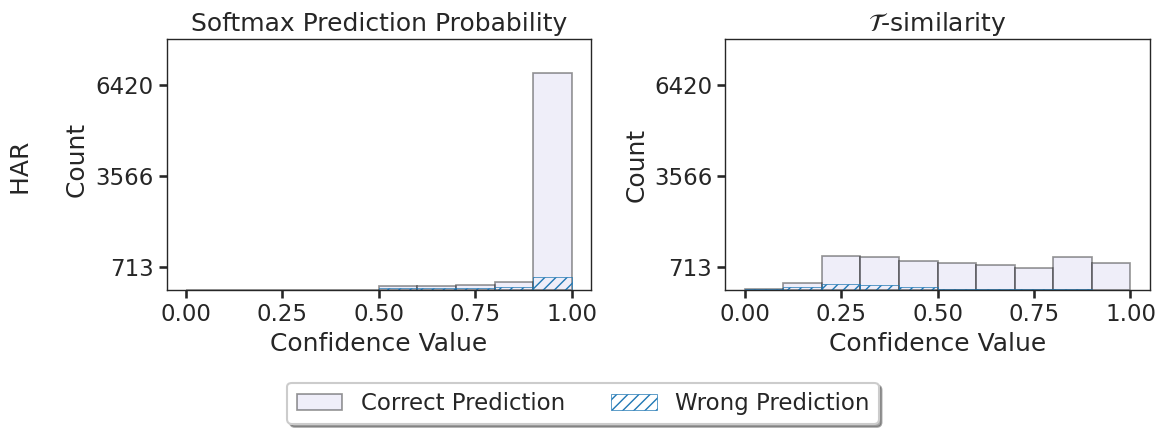

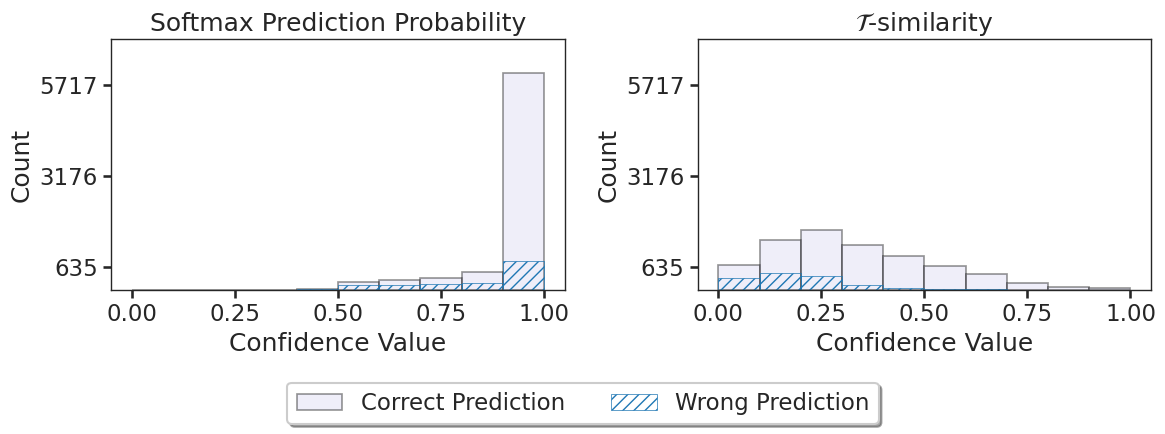

In [105]:
dataset_name = "har"
seed = 0
nb_lab_samples_per_class = 50
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
for format in ["svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "HAR \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            side_caption=side_caption,
        )

### For all datasets

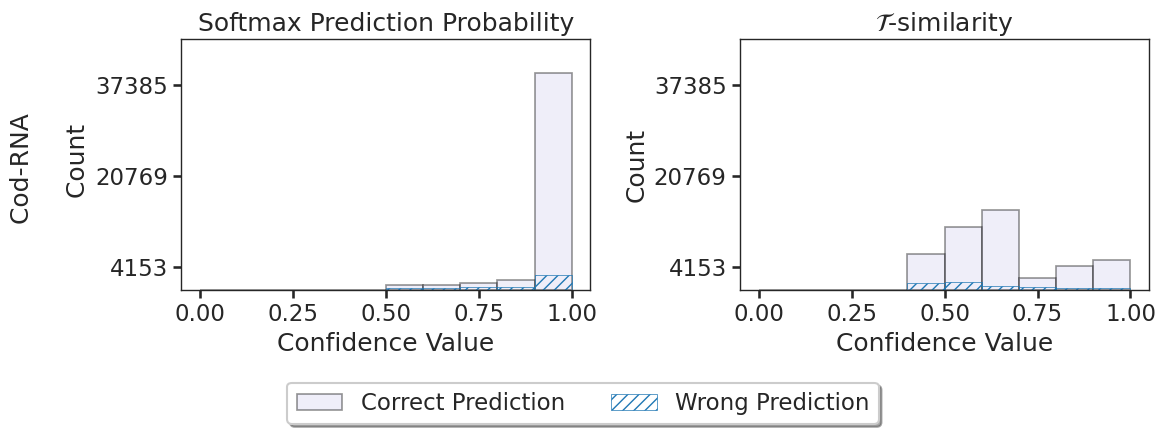

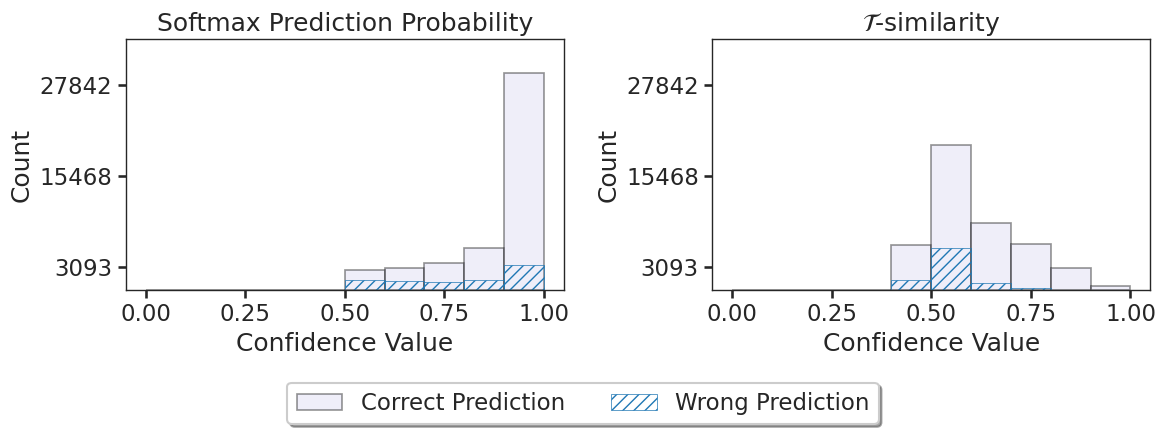

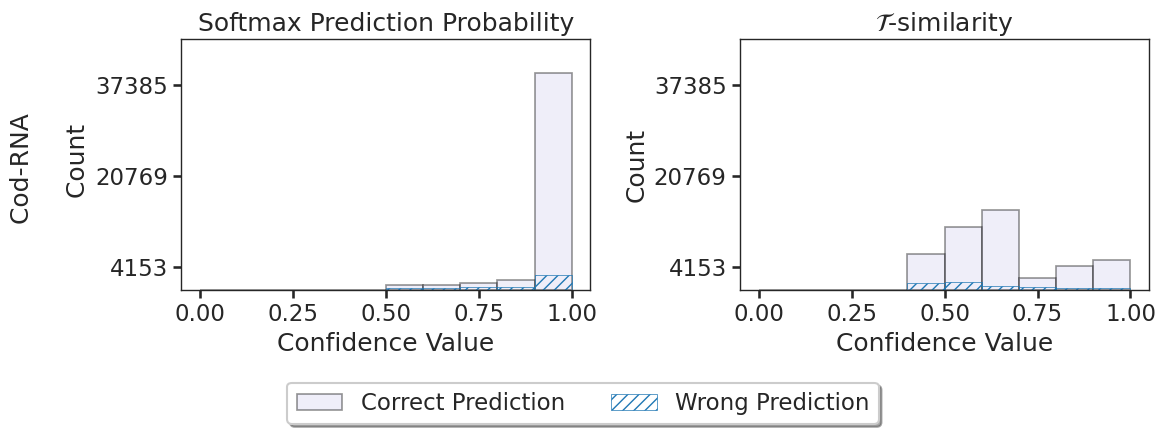

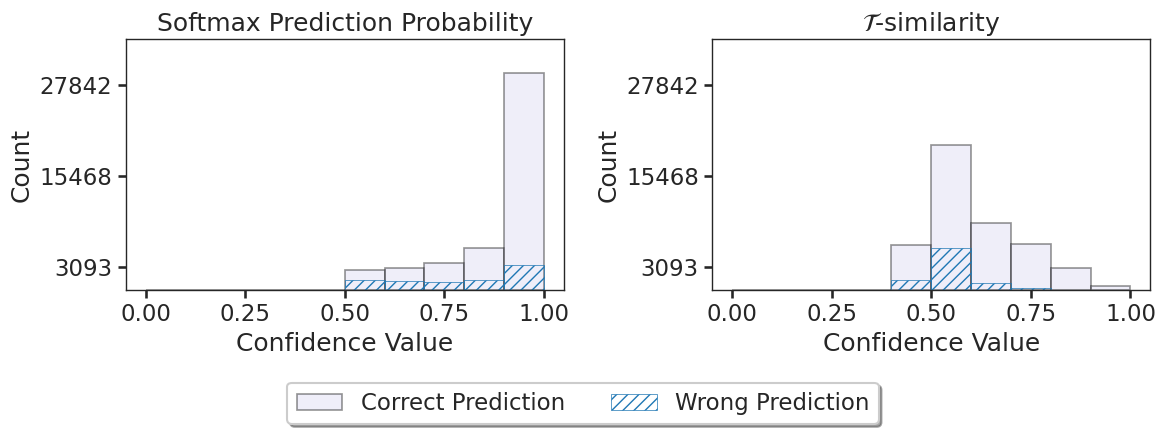

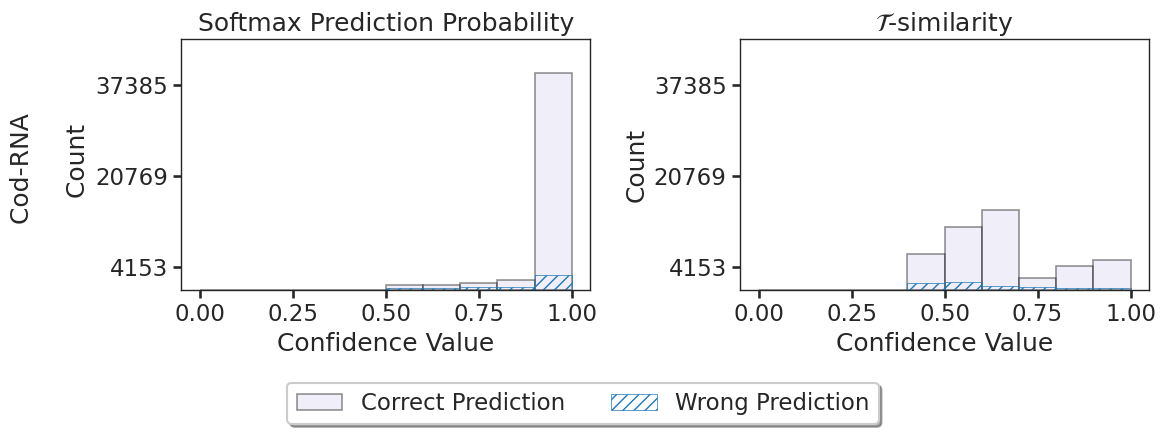

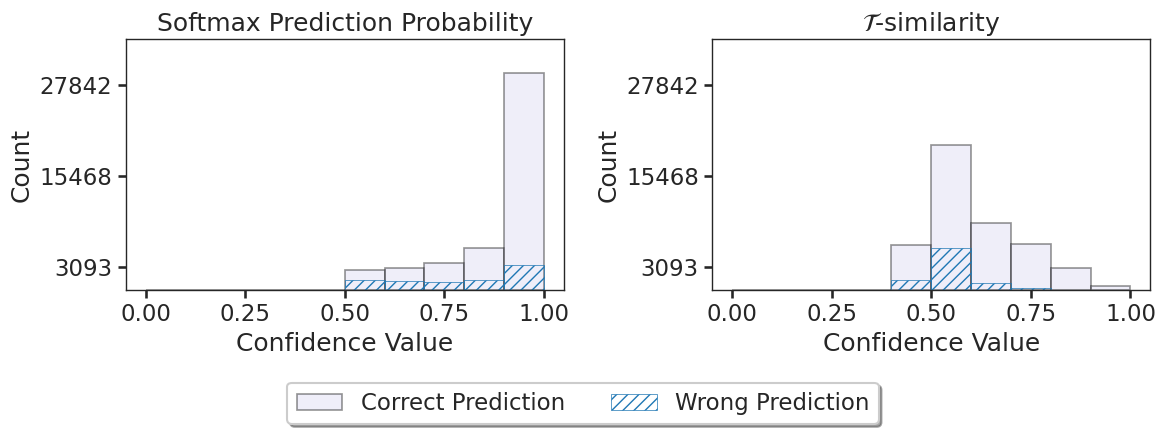

In [106]:
## Less size
dataset_name = "codrna"
seed = 0
nb_lab_samples_per_class = 50
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
dpi = 100
for format in ["pdf", "svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Cod-RNA \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            dpi=dpi,
            side_caption=side_caption,
        )

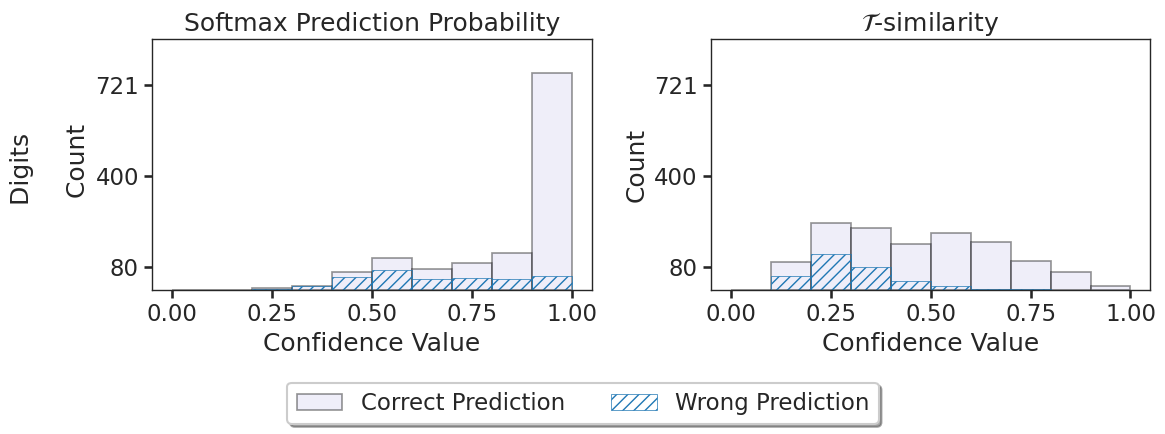

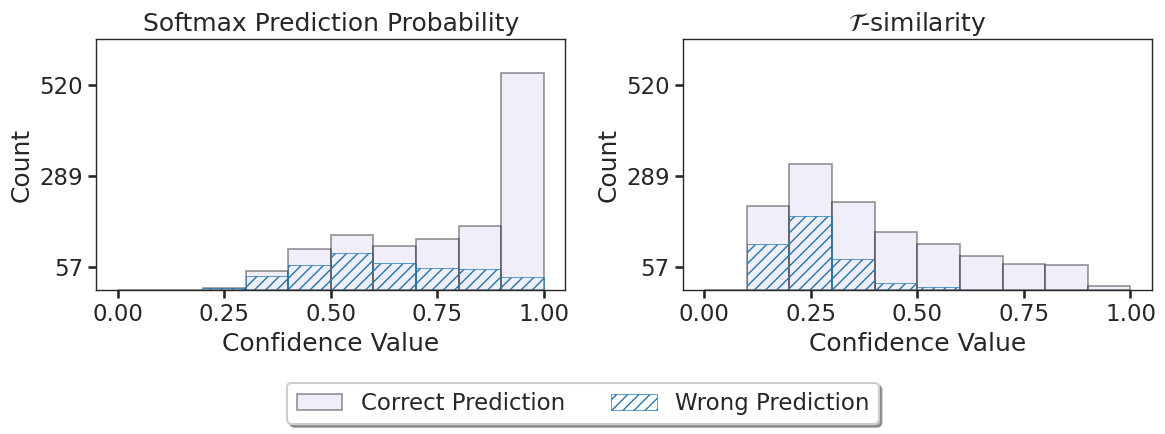

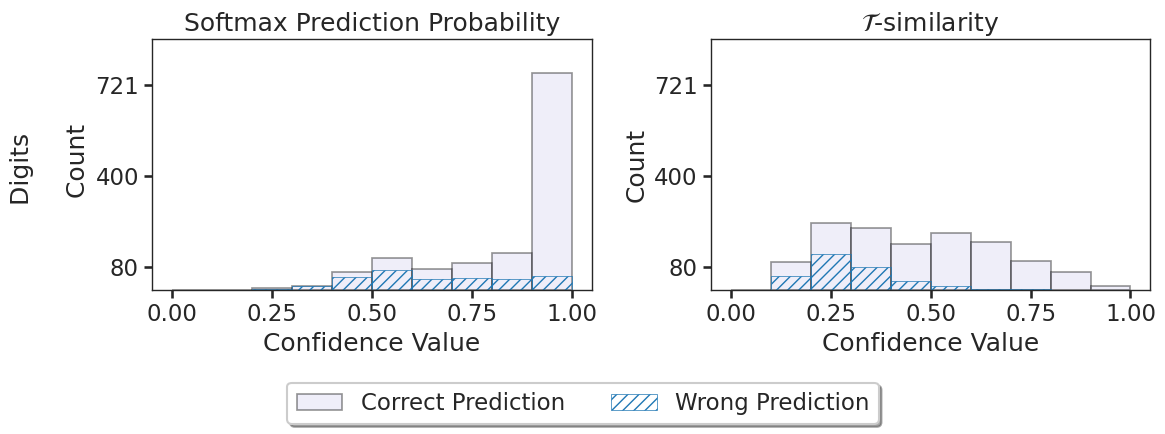

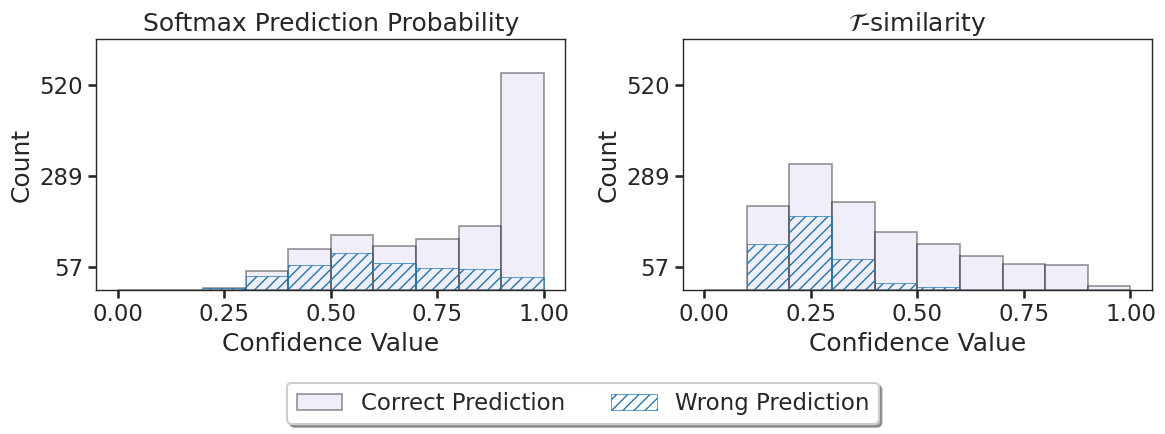

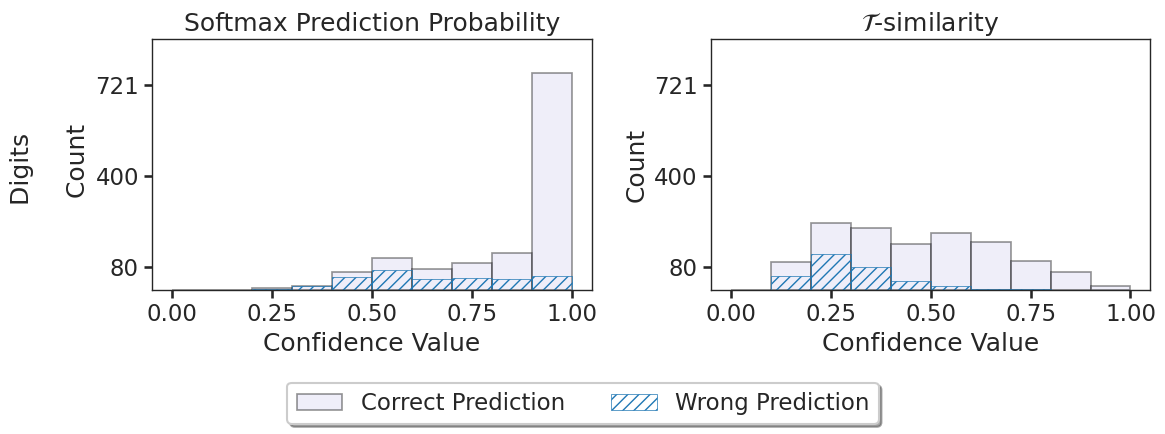

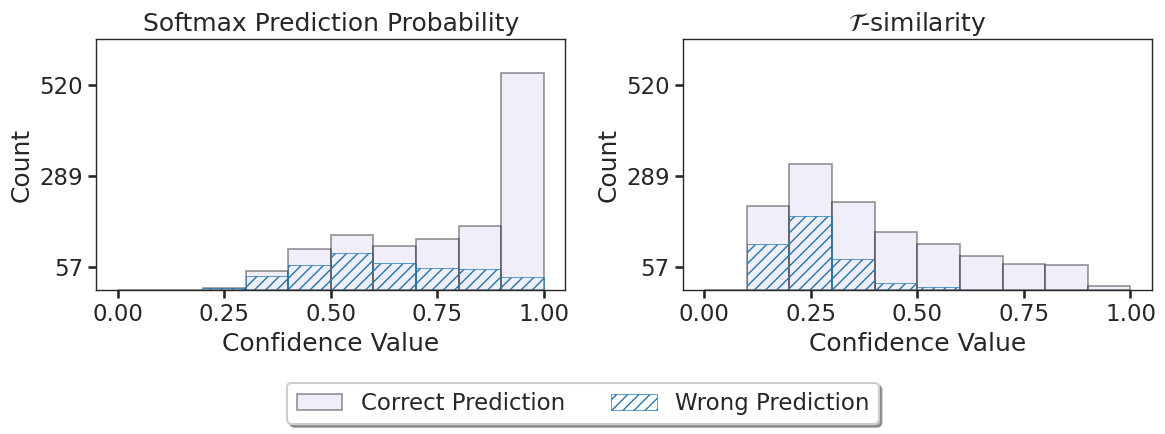

In [107]:
## Less size
dataset_name = "digits"
seed = 0
nb_lab_samples_per_class = 10
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
dpi = 100
for format in ["pdf", "svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Digits \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            dpi=dpi,
            side_caption=side_caption,
        )

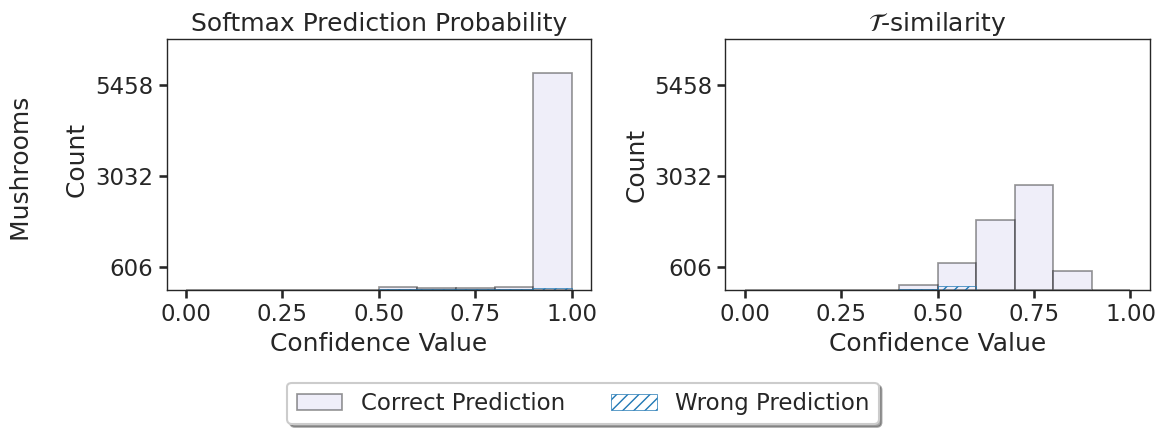

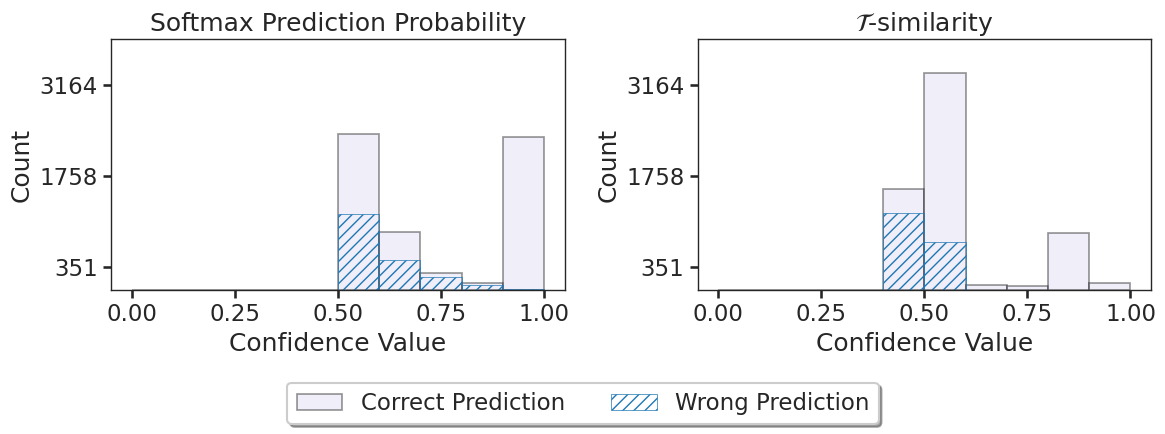

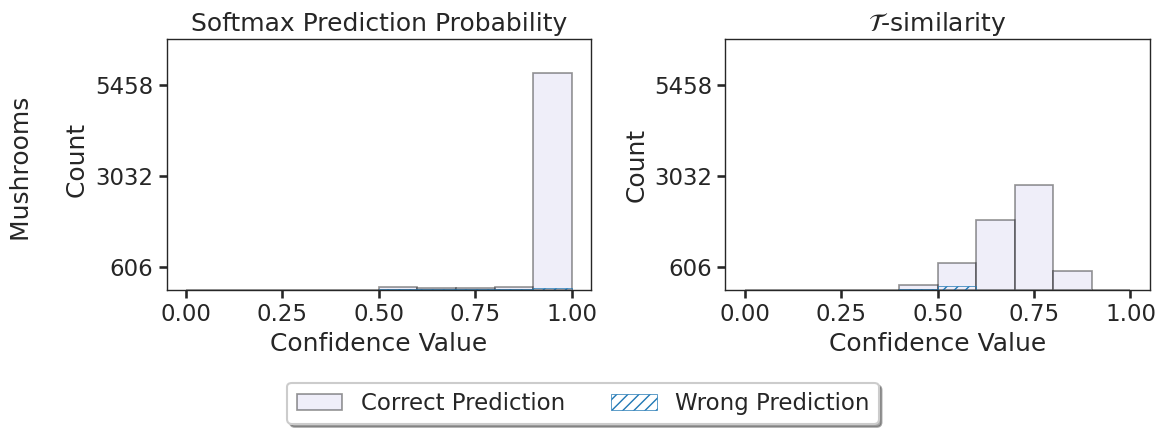

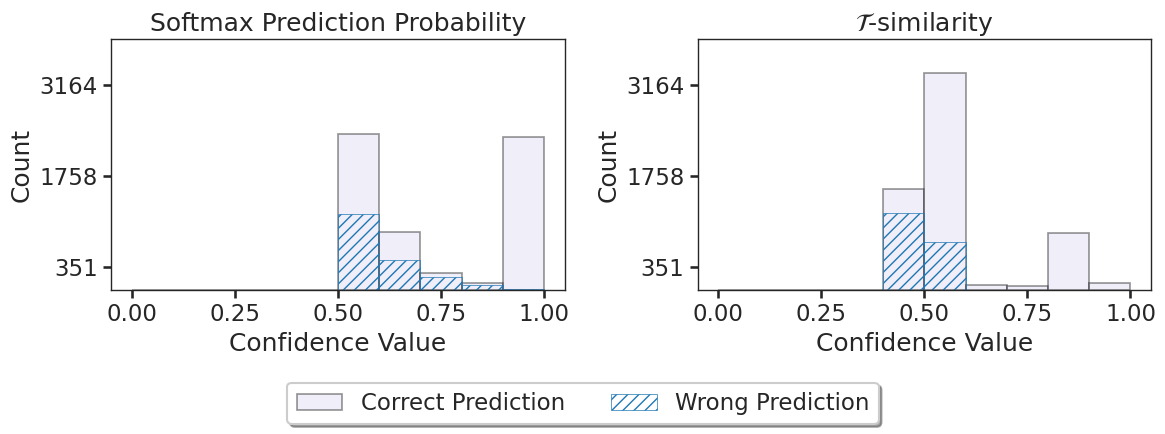

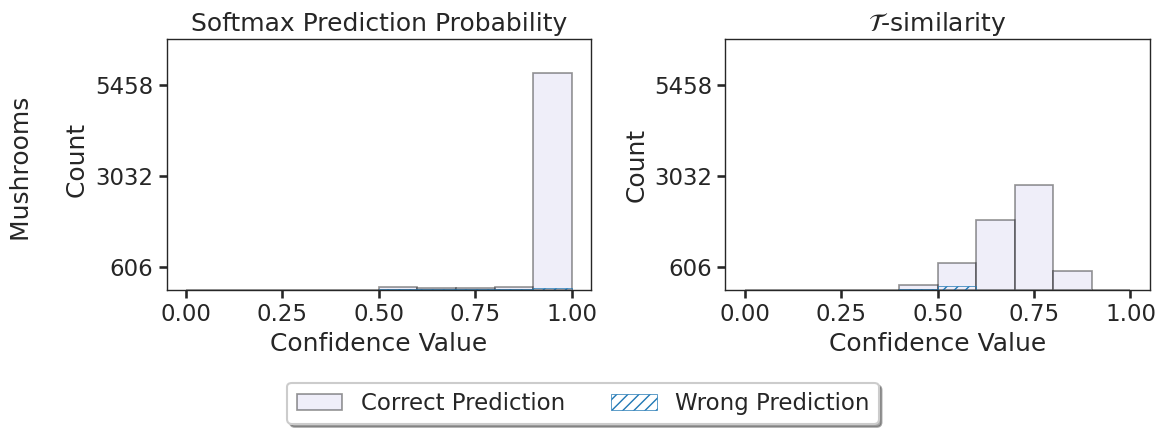

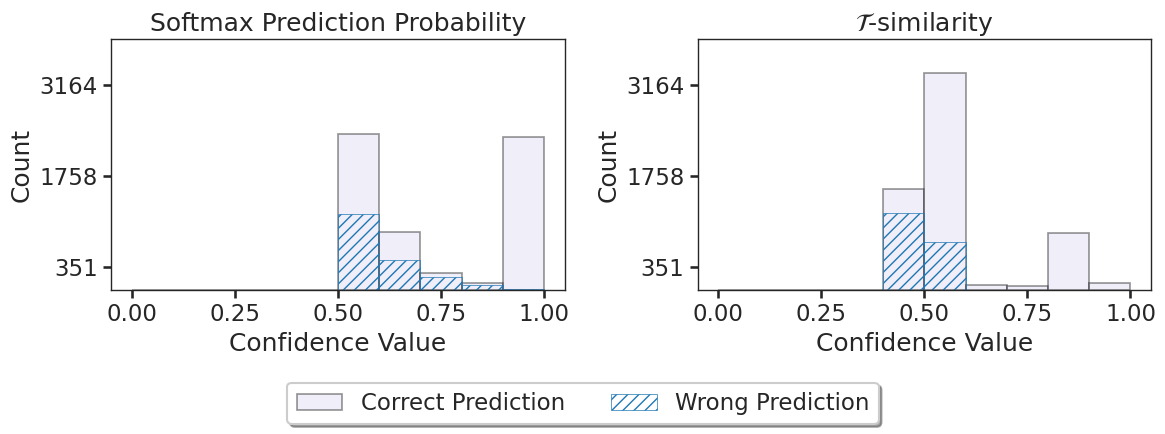

In [108]:
## Less size
dataset_name = "mushrooms"
seed = 0
nb_lab_samples_per_class = 40
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
dpi = 100
for format in ["pdf", "svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Mushrooms \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            dpi=dpi,
            side_caption=side_caption,
        )

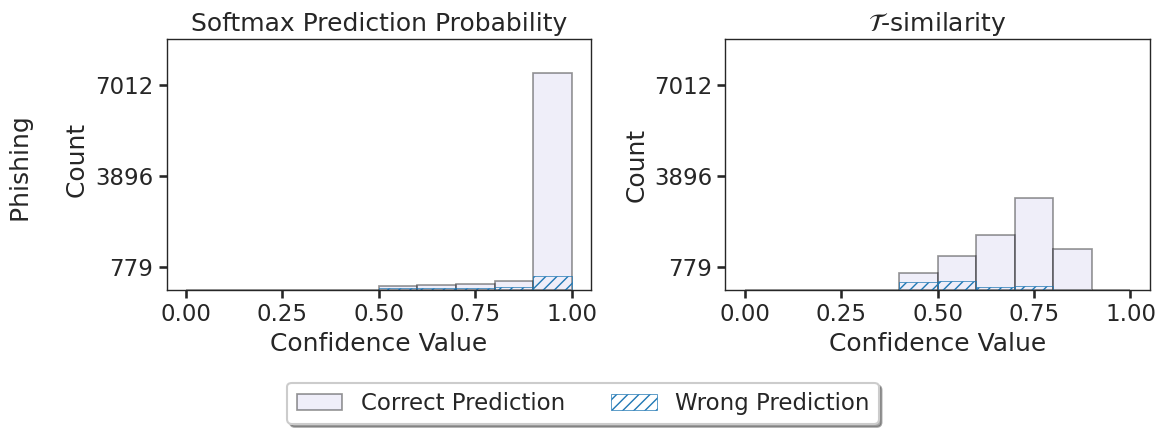

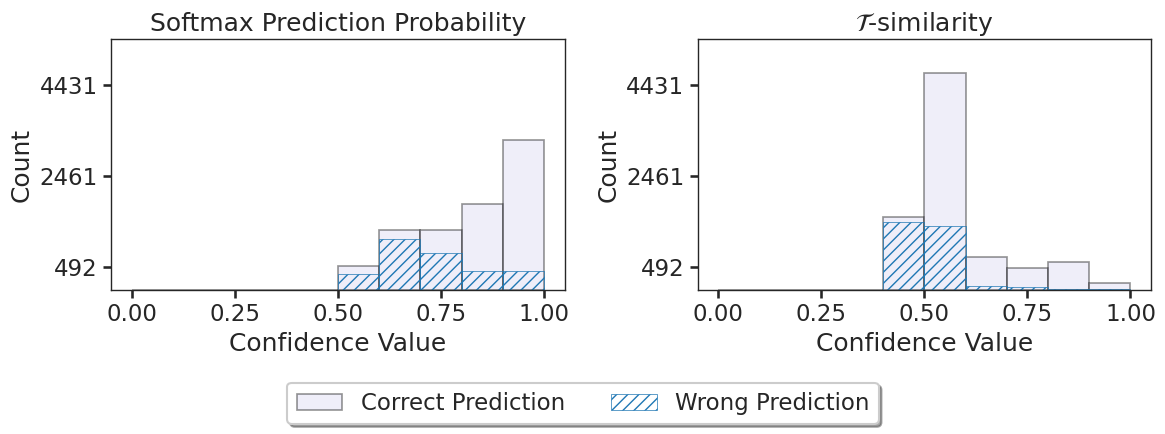

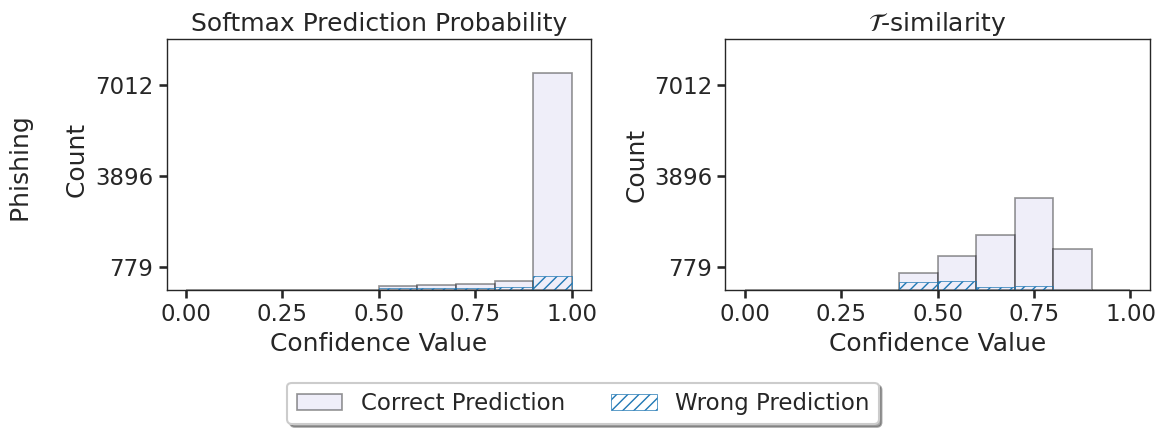

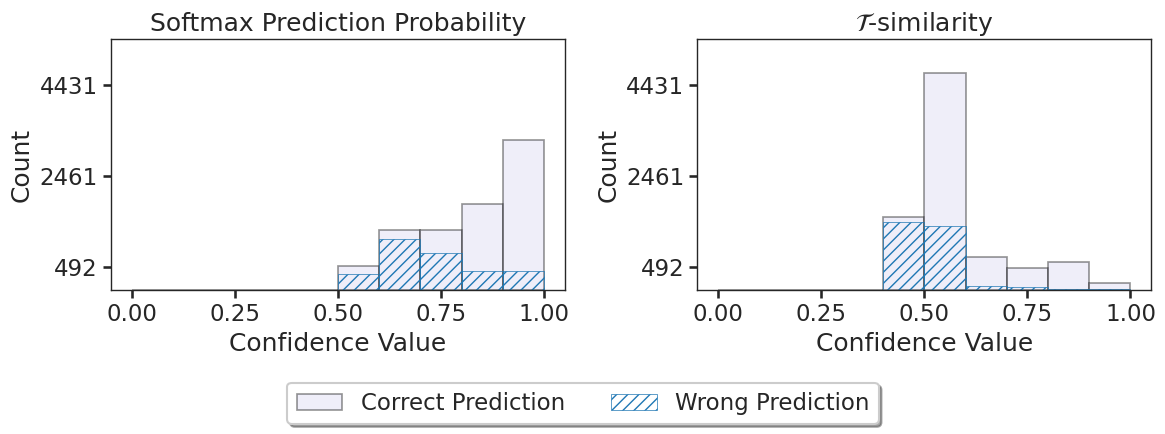

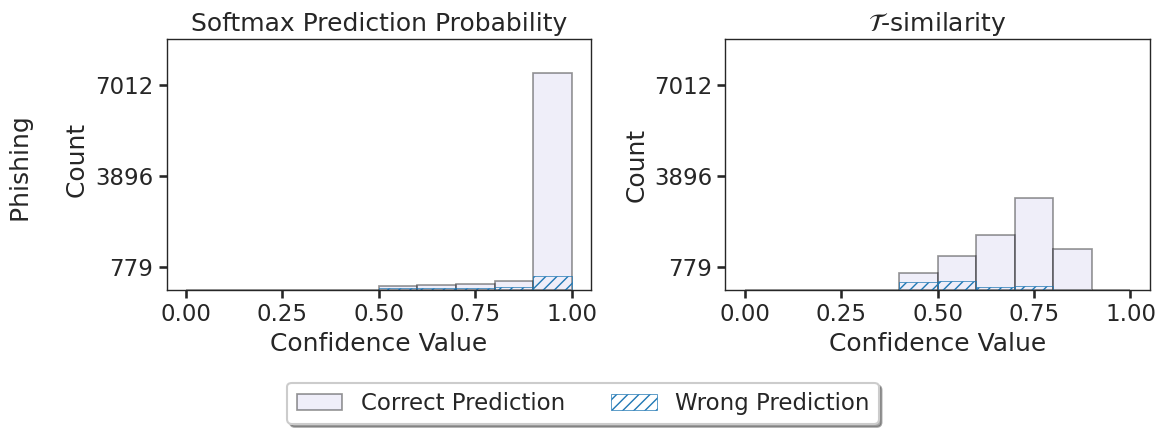

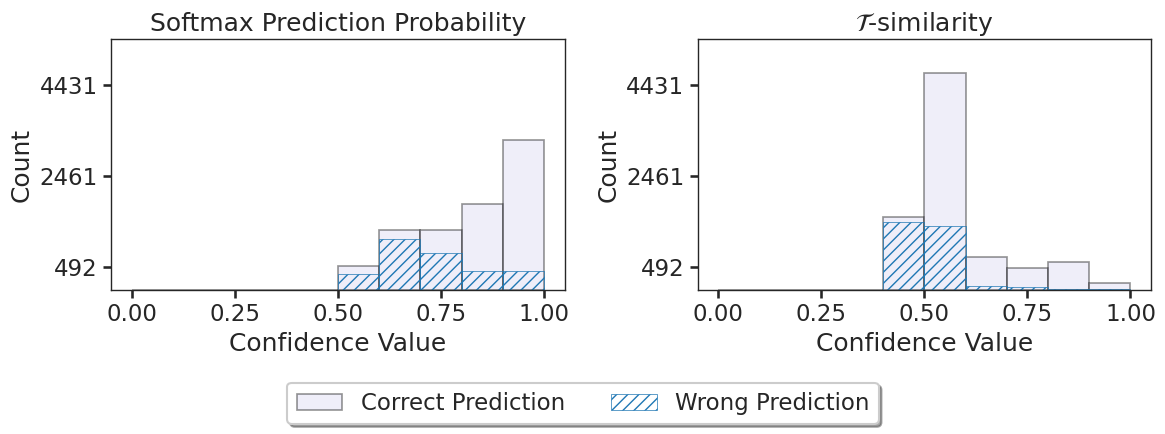

In [109]:
## Less size
dataset_name = "phishing"
seed = 0
nb_lab_samples_per_class = 50
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
dpi = 100
for format in ["pdf", "svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Phishing \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            dpi=dpi,
            side_caption=side_caption,
        )

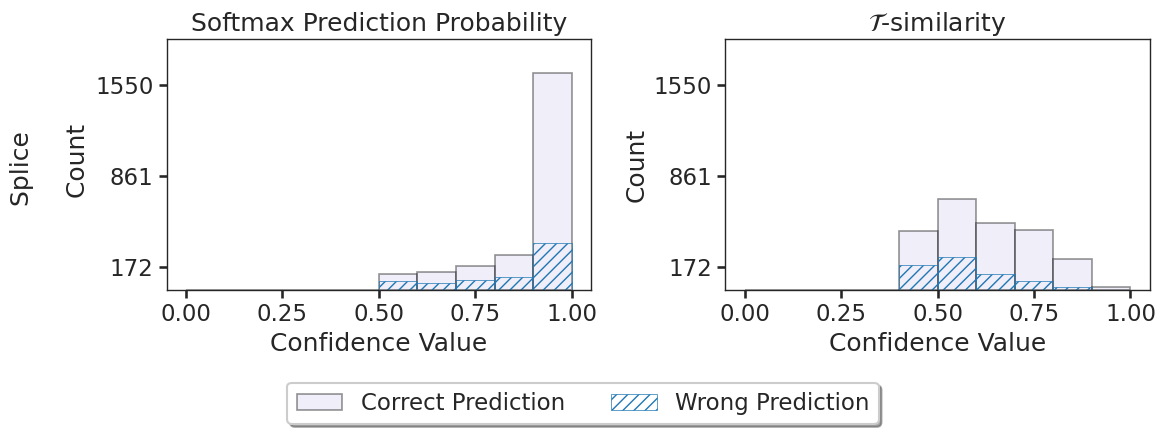

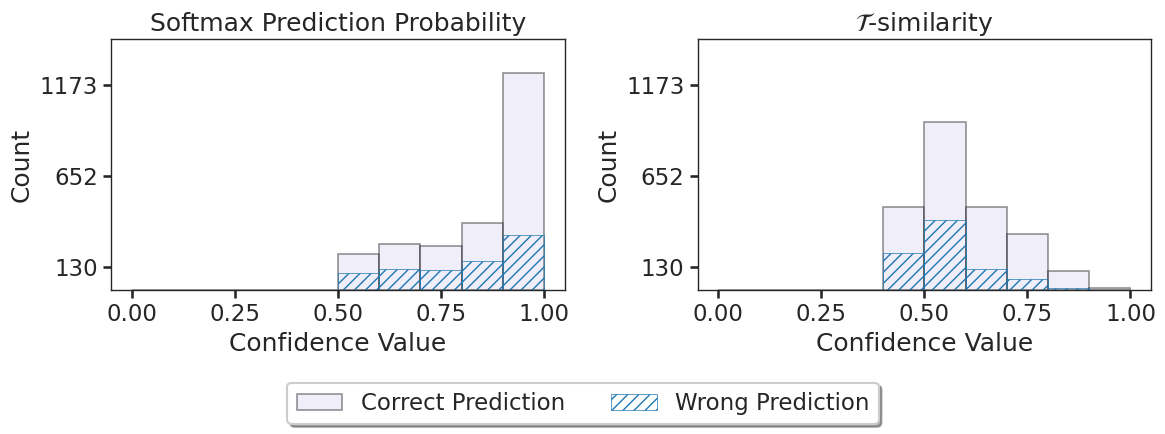

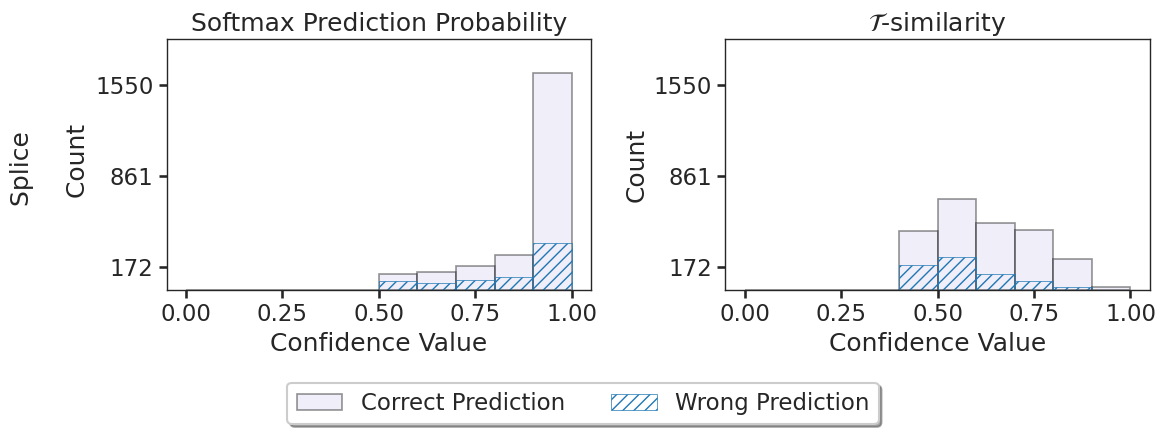

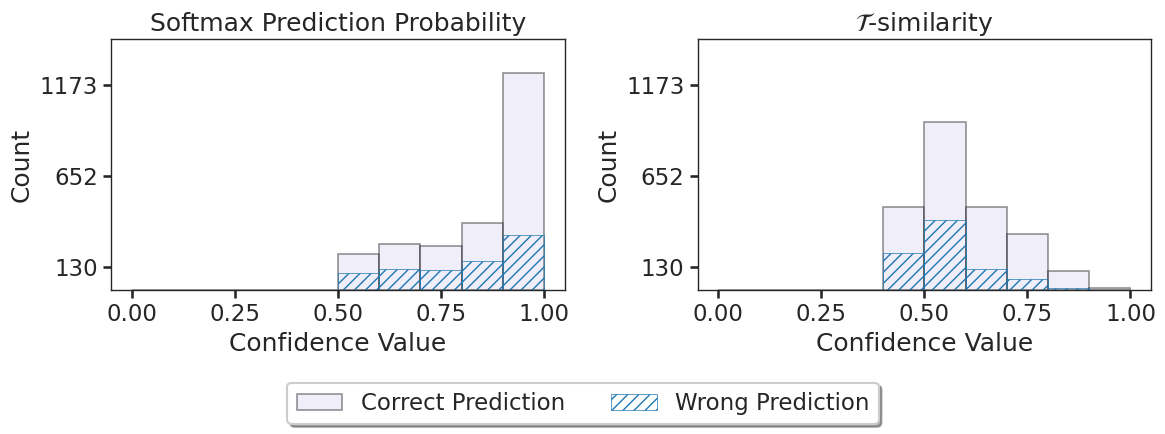

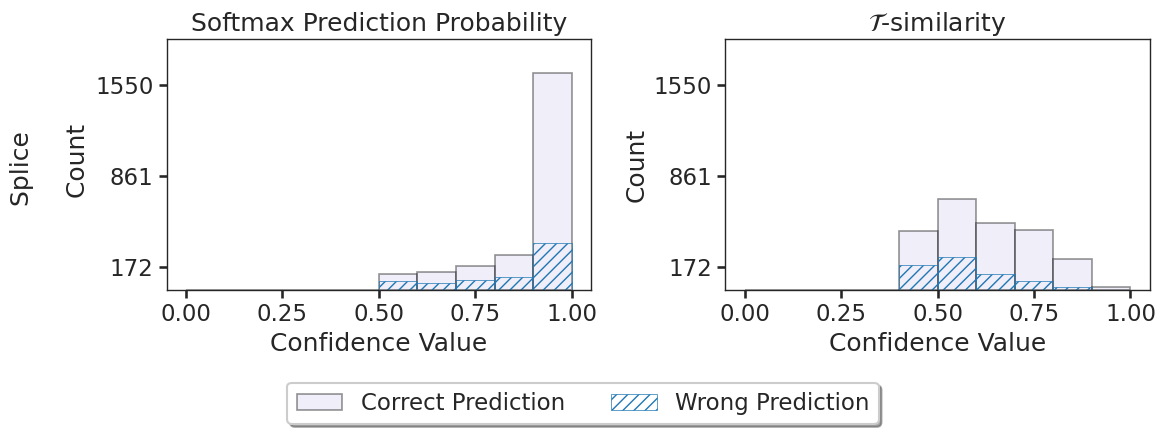

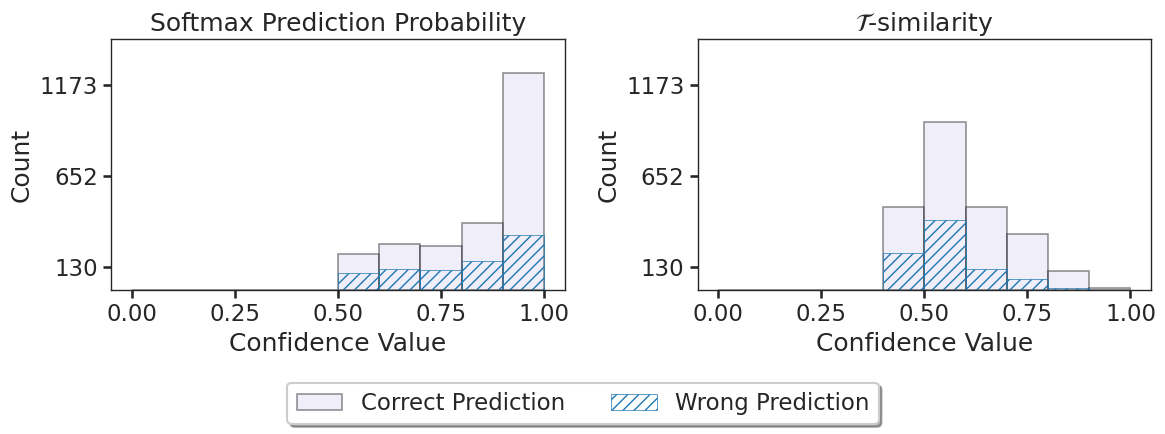

In [110]:
## Less size
dataset_name = "splice_big"
seed = 0
nb_lab_samples_per_class = 20
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
dpi = 100
for format in ["pdf", "svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Splice \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            dpi=dpi,
            side_caption=side_caption,
        )

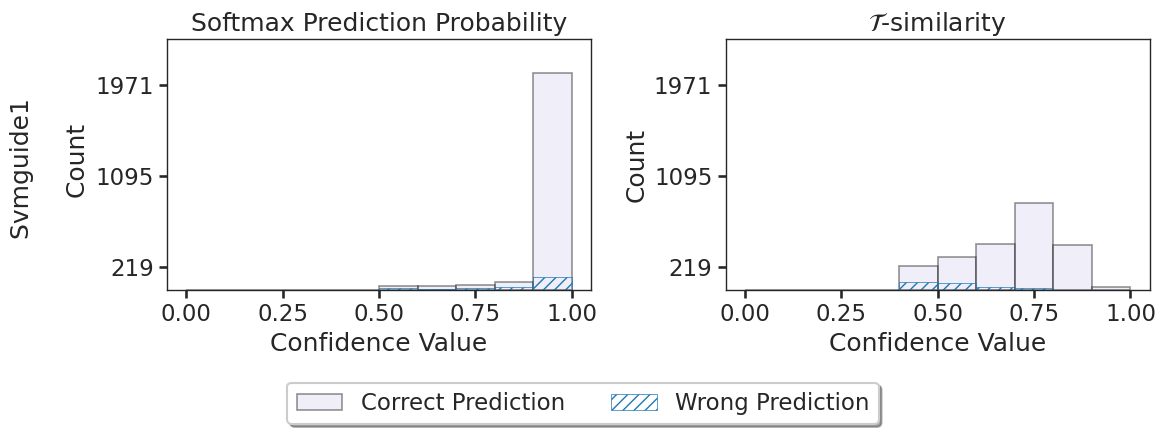

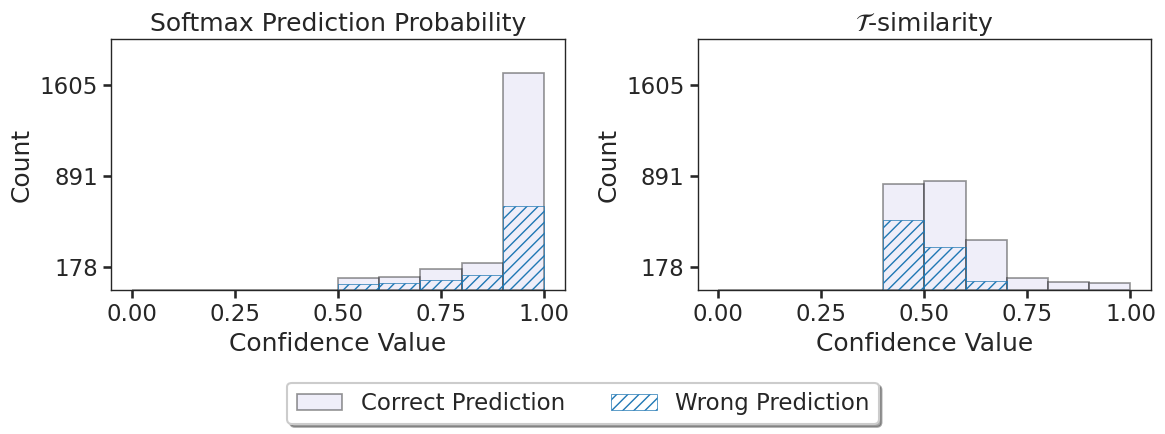

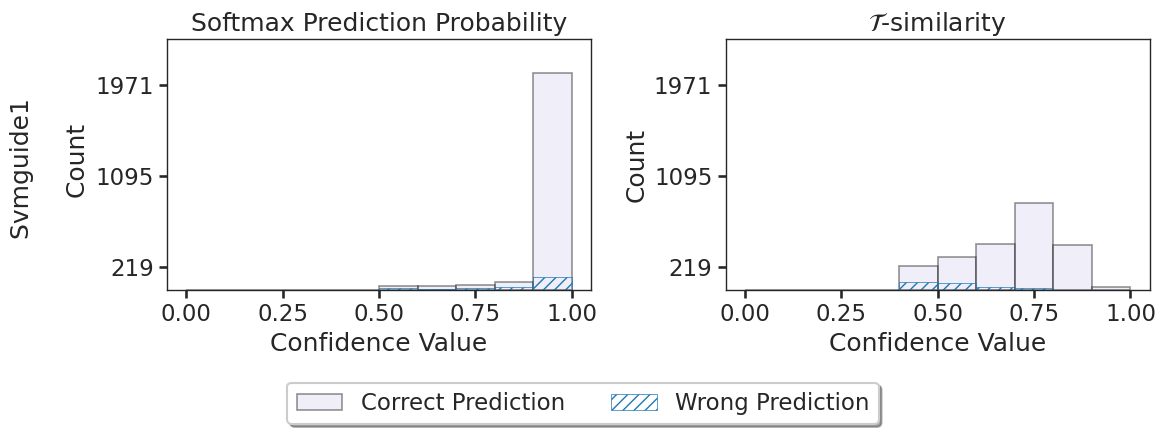

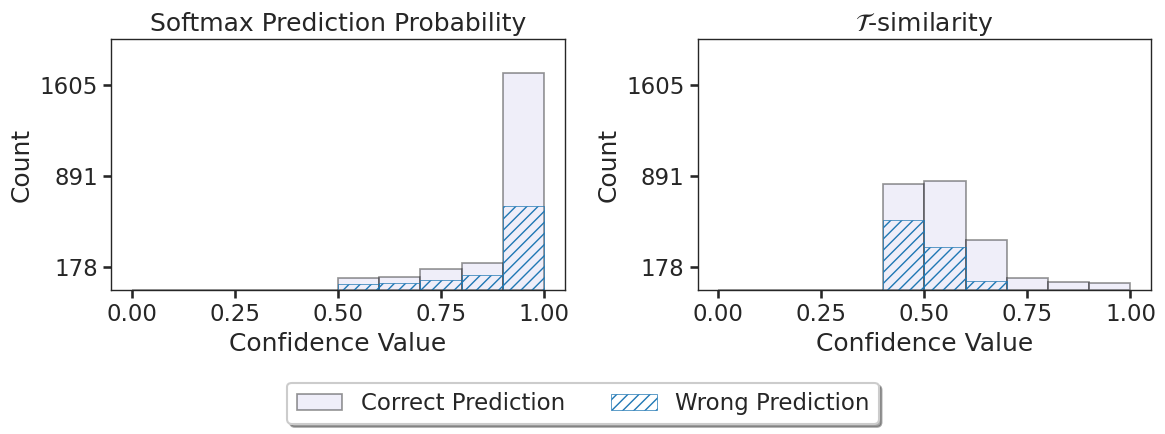

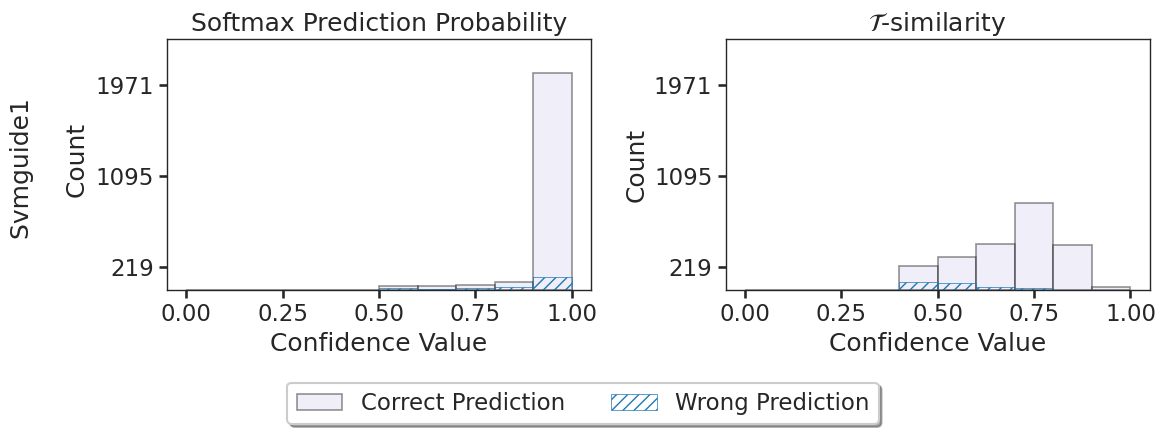

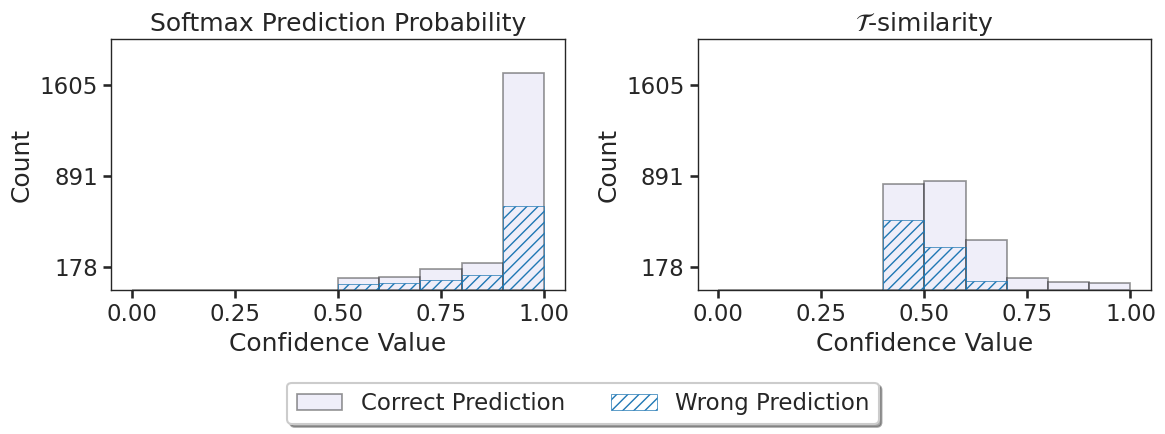

In [111]:
## Less size
dataset_name = "svmguide1"
seed = 0
nb_lab_samples_per_class = 20
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
dpi = 100
for format in ["pdf", "svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Svmguide1 \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            dpi=dpi,
            side_caption=side_caption,
        )

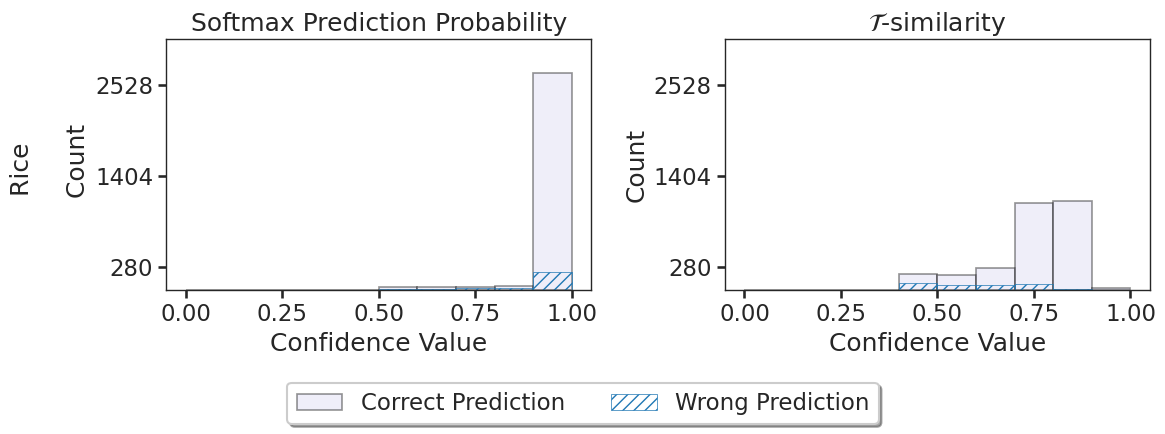

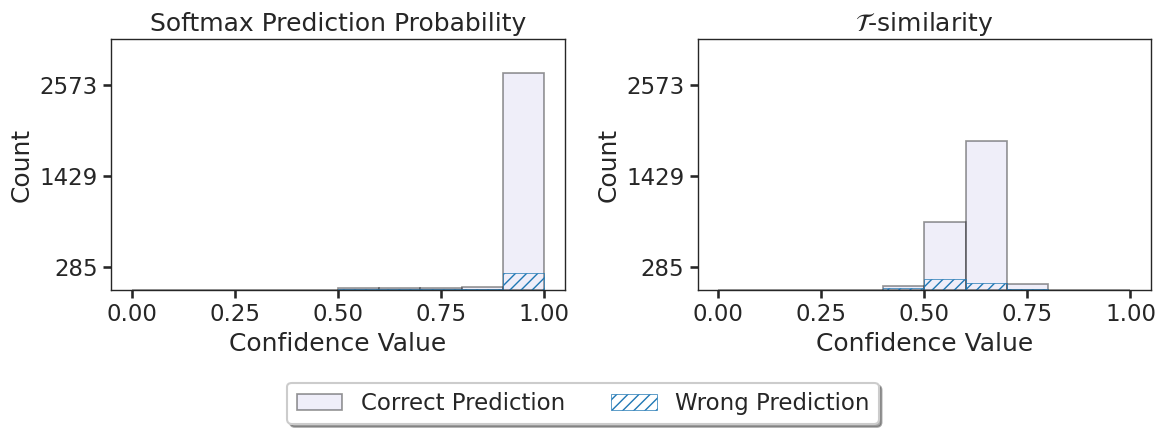

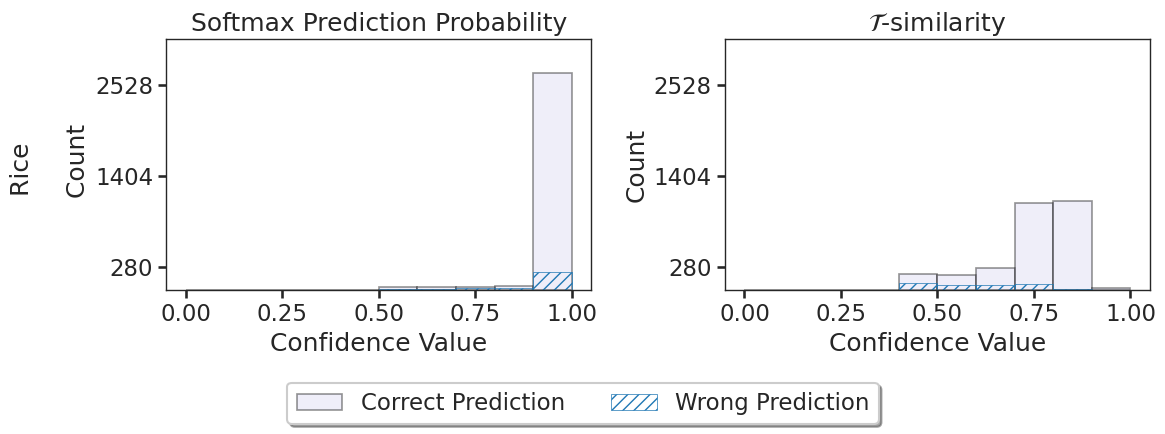

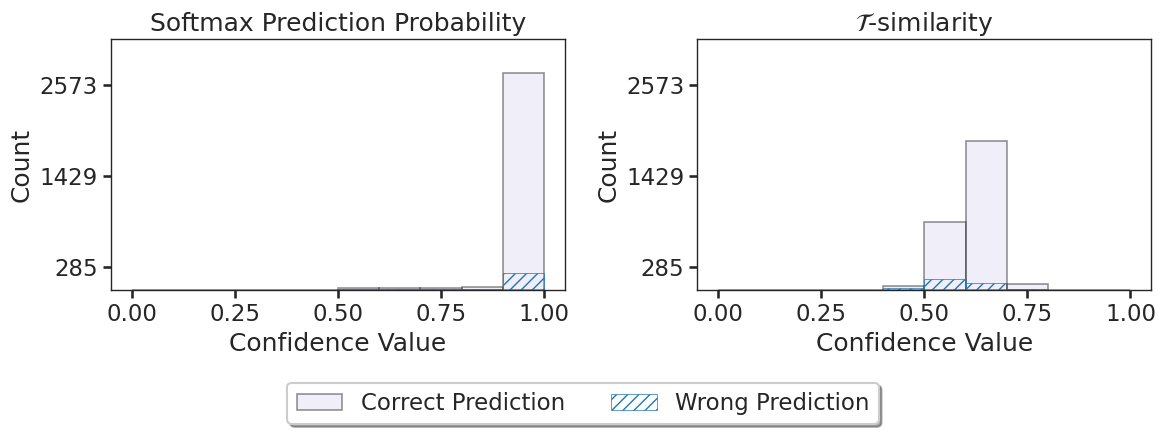

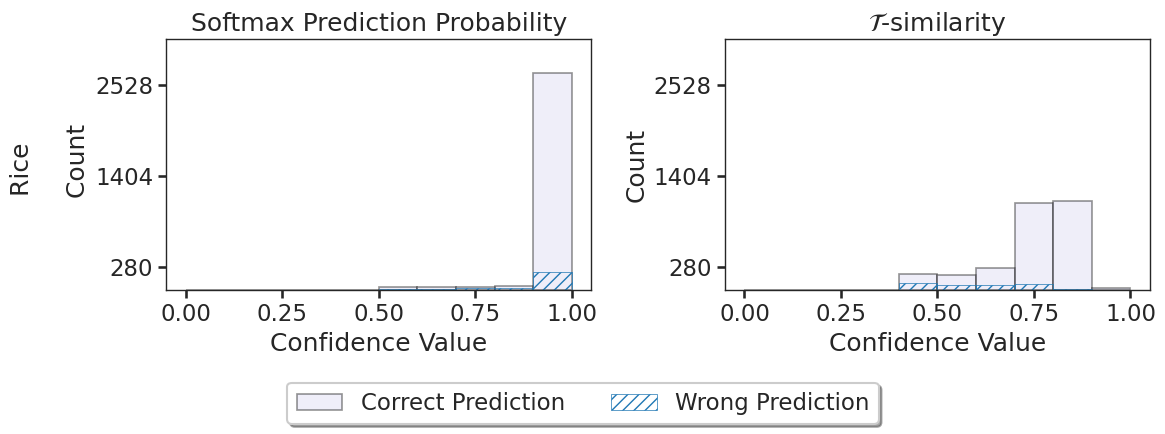

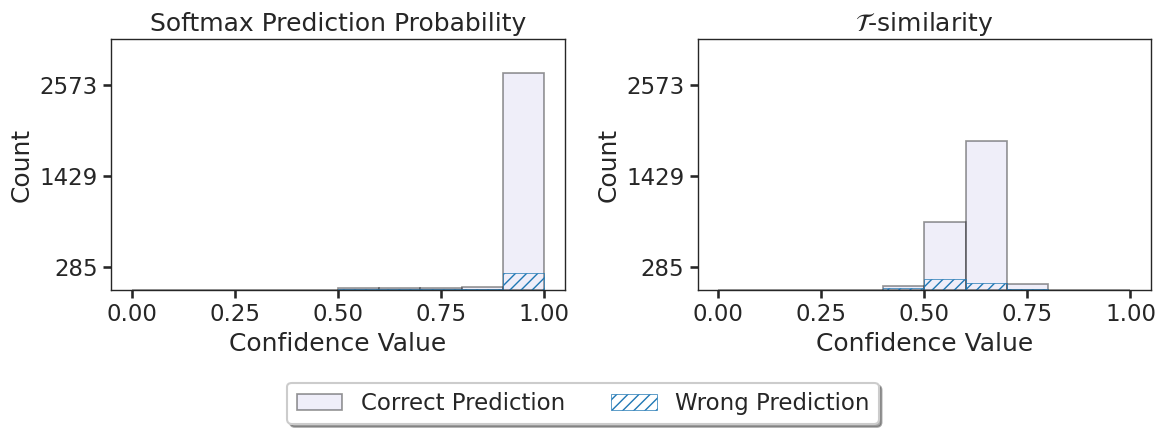

In [112]:
## Less size
dataset_name = "rice"
seed = 0
nb_lab_samples_per_class = 15
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
dpi = 100
for format in ["pdf", "svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "Rice \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            dpi=dpi,
            side_caption=side_caption,
        )

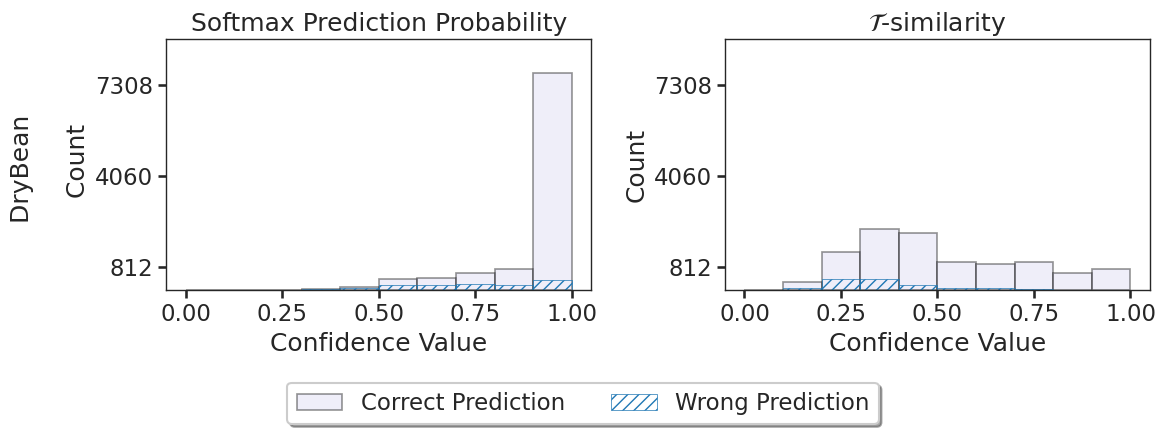

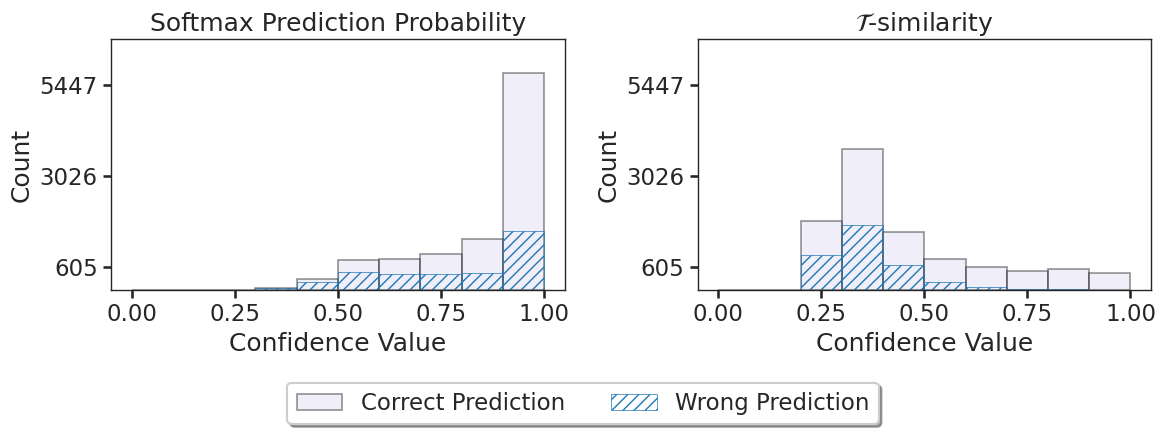

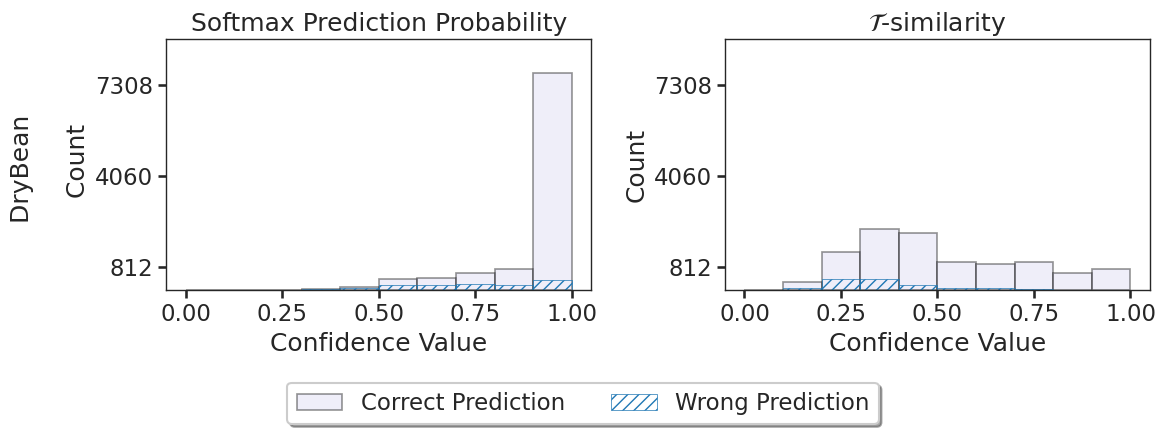

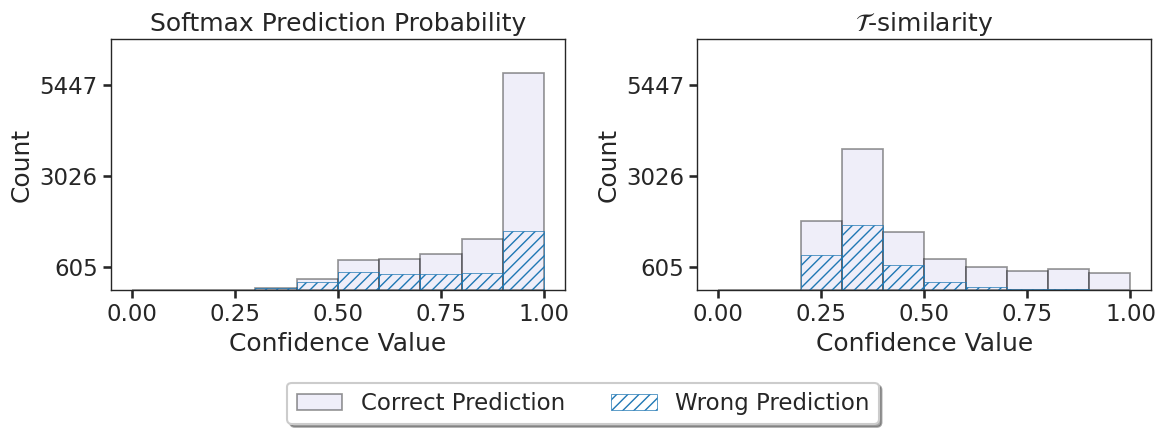

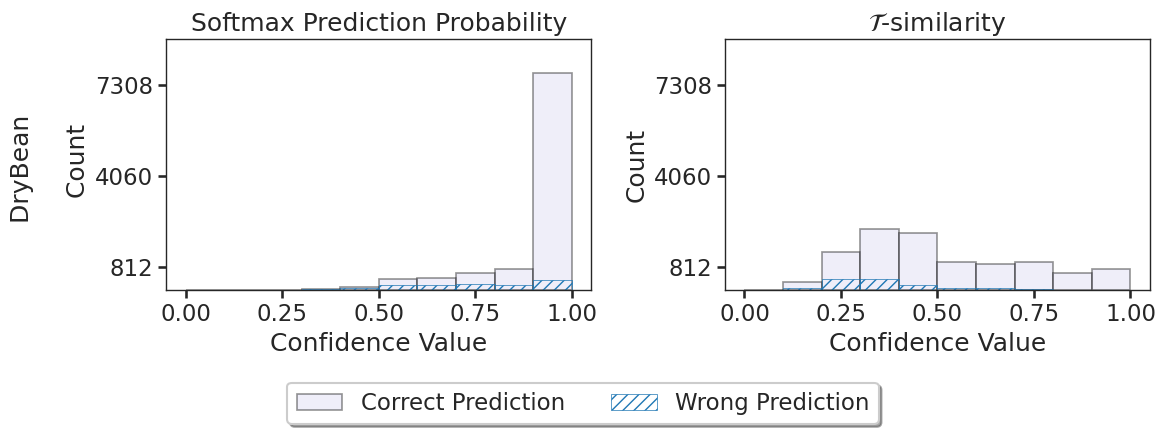

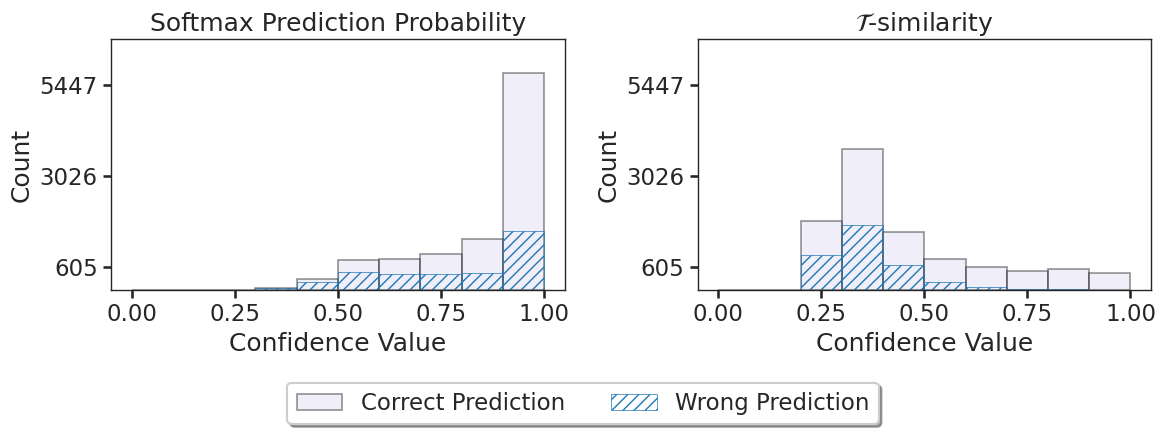

In [113]:
## Less size
dataset_name = "dry_bean"
seed = 0
nb_lab_samples_per_class = 15
num_epochs = 5
gamma_u = 1
figsize = (12, 4)
save = True
dpi = 100
for format in ["pdf", "svg", "png"]:
    for selection_bias in ["balanced", "pca"]:
        if selection_bias == "balanced":
            side_caption = "DryBean \n"
        else:
            side_caption = None
        filename = f"calibrated_similarity_{dataset_name}_{selection_bias}.{format}"
        get_barplots(
            dataset_name,
            seed,
            nb_lab_samples_per_class,
            selection_bias,
            num_epochs,
            gamma_u,
            figsize=figsize,
            save=save,
            format=format,
            filename=filename,
            dpi=dpi,
            side_caption=side_caption,
        )